In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm # linear regression
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scanpy as sc
from gprofiler import GProfiler
import os
import SpatialproxseqClasses as SPC


#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [2]:
# Load the .h5ad file
adata_protein_gc_follicle = sc.read("combined_GC_follicle_protein_ABD_remove_batch_effect.h5ad")
adata_pp_gc_follicle = sc.read("combined_GC_follicle_protein_pair_ABD_remove_batch_effect.h5ad")
adata_fraction_oeverlap_gc_follicle = sc.read("combined_weighted_fraction_ABD_data_remove_batch_effect.h5ad")


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_21969/2030885903.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_fraction_oeverlap_gc_follicle, resolution=0.5)


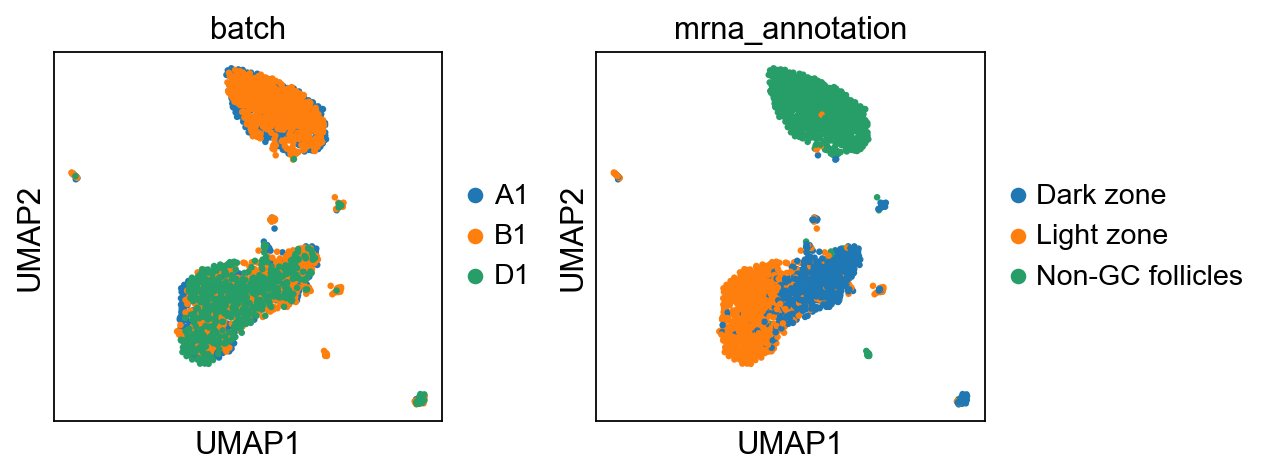

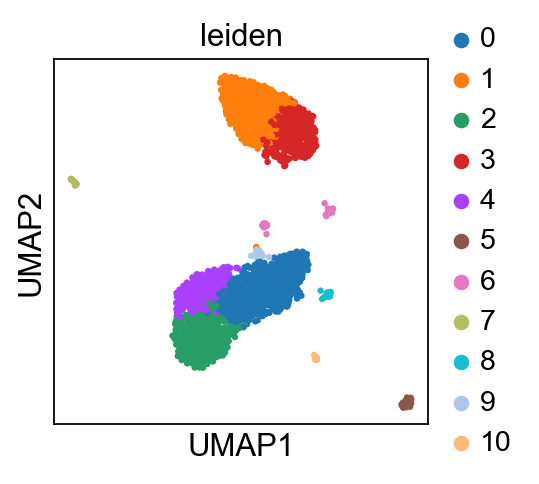

In [3]:
# Leiden clustering to identify substructures
sc.tl.leiden(adata_fraction_oeverlap_gc_follicle, resolution=0.5)
sc.set_figure_params(figsize=(3, 3))
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["batch", "mrna_annotation", ])
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=[ "leiden"])

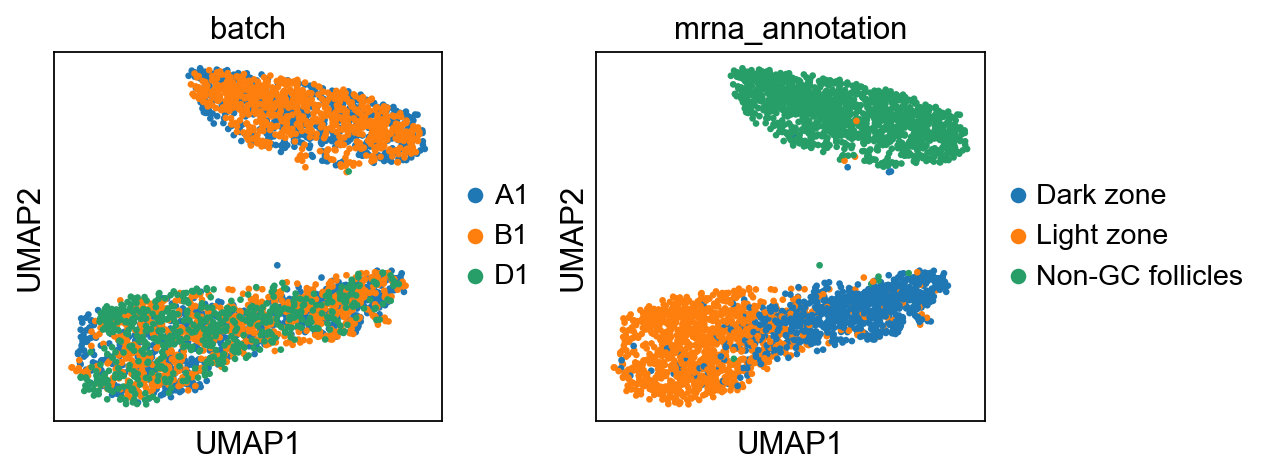

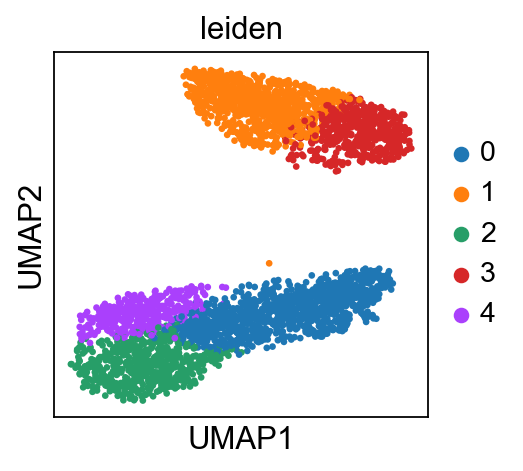

In [4]:
# filter out Leiden clusters if still needed
main_clusters = ["0", "1", "2", "3", "4"]
adata_fraction_oeverlap_gc_follicle = adata_fraction_oeverlap_gc_follicle[
    adata_fraction_oeverlap_gc_follicle.obs["leiden"].isin(main_clusters)
].copy()
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["batch", "mrna_annotation",])
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["leiden"])



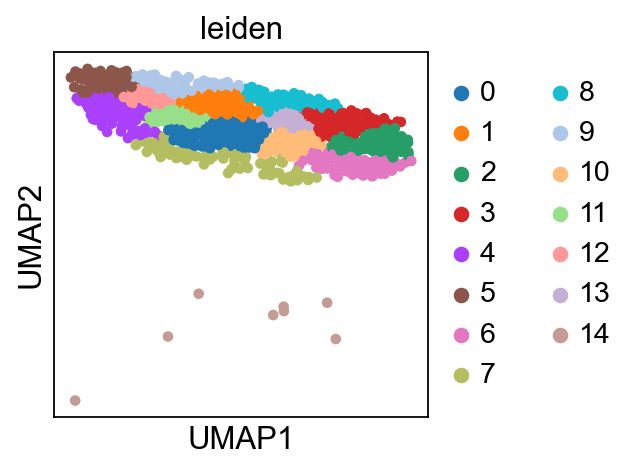

In [211]:
# Step 1: Further cluster Non-GC follicles
adata_pf = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] == "Non-GC follicles"].copy()
sc.pp.neighbors(adata_pf, use_rep="X_umap")
sc.tl.leiden(adata_pf, resolution=0.5)

sc.pl.umap(adata_pf, color="leiden")

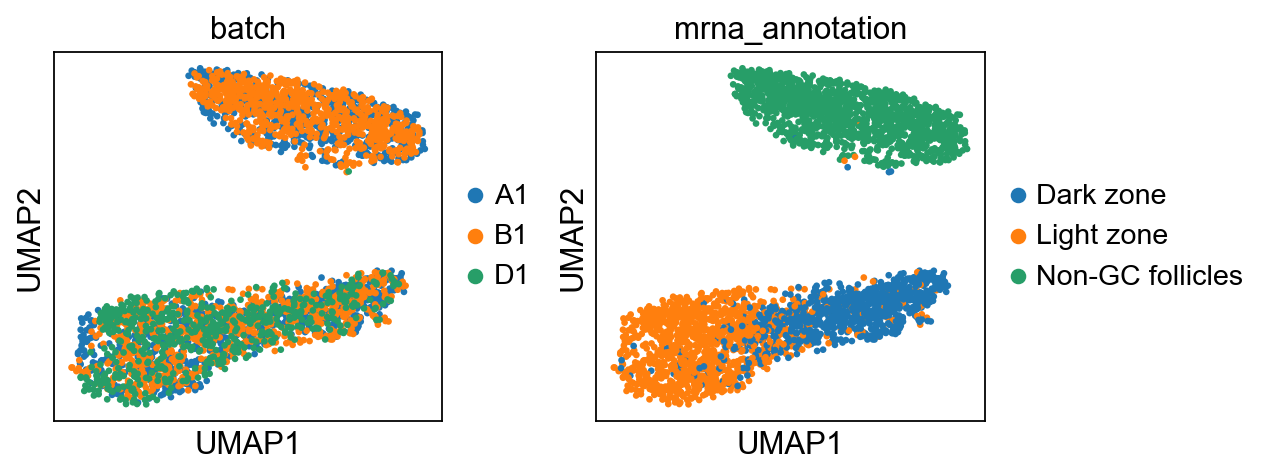

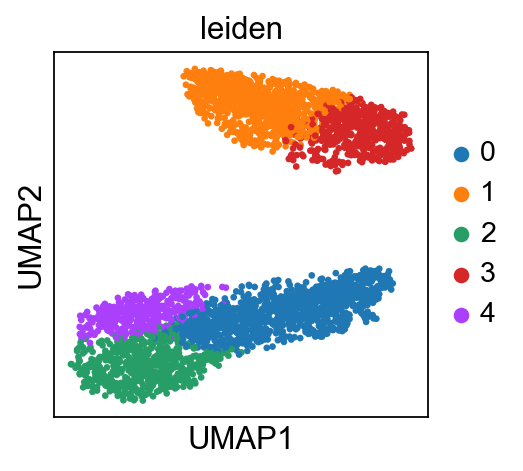

In [212]:

# Step: Exclude Leiden clusters "14"
adata_pf_filtered = adata_pf[~adata_pf.obs["leiden"].isin(["14", ])].copy()

# Step 3: Combine with other clusters 
keep_other_cells = adata_fraction_oeverlap_gc_follicle.obs[
    adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] != "Non-GC follicles"
].index

adata_fraction_oeverlap_gc_follicle = adata_fraction_oeverlap_gc_follicle[adata_pf_filtered.obs_names.union(keep_other_cells)].copy()
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["batch", "mrna_annotation", ])
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["leiden"])

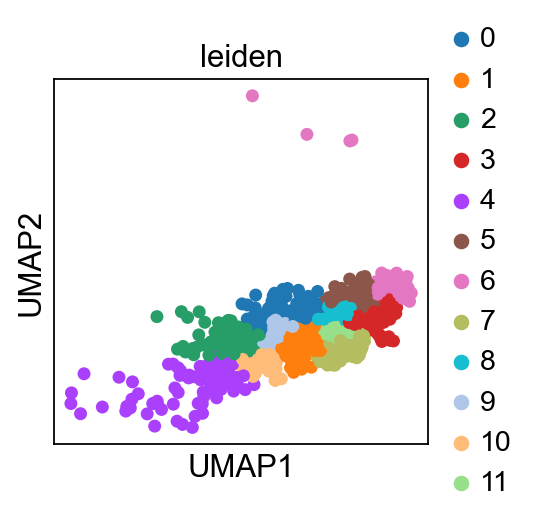

In [213]:
# Step 1: Further cluster Dark zone
adata_dz = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] == "Dark zone"].copy()
sc.pp.neighbors(adata_dz, use_rep="X_umap")
sc.tl.leiden(adata_dz, resolution=0.5)
sc.pl.umap(adata_dz, color="leiden")


In [214]:
# Extract UMAP coordinates
adata_dz = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] == "Dark zone"].copy()
umap = adata_dz.obsm["X_umap"]

# Identify cells that are in Dark zone
target_mask = adata_dz.obs["mrna_annotation"].isin([
    "Dark zone"
])

# Further filter
exclude_mask = target_mask & (
    ((umap[:, 0] > 5) & (umap[:, 1] > 10))
)

# Create a new AnnData object excluding the undesired cells
adata_dz_filtered = adata_dz[~exclude_mask].copy()

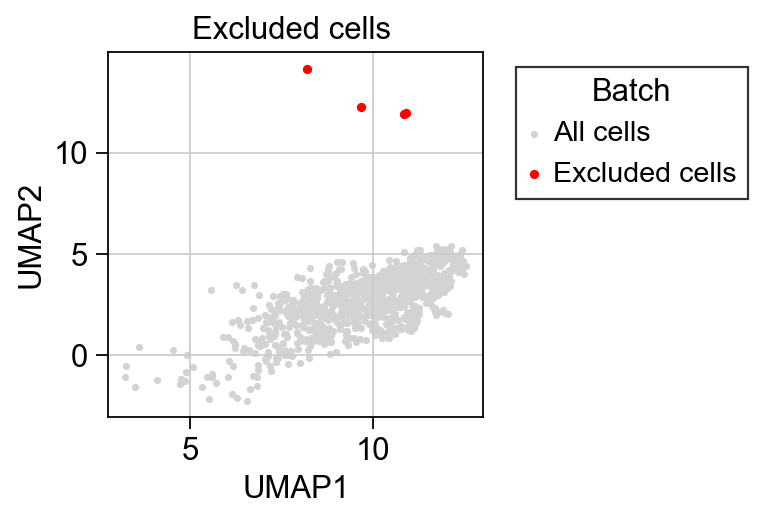

In [215]:
plt.figure(figsize=(3, 3))
plt.scatter(umap[:, 0], umap[:, 1], s=5, c="lightgray", label="All cells")
plt.scatter(umap[exclude_mask, 0], umap[exclude_mask, 1], s=10, c="red", label="Excluded cells")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.title("Excluded cells ")
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [216]:
# Keep all cells that are not Dark zone
keep_other_cells = adata_fraction_oeverlap_gc_follicle.obs[
    ~adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"].isin([
    "Dark zone"
    ])
].index
# Cells that passed filtering 
keep_filtered_cells = adata_dz_filtered.obs_names
# Combine both sets of cells
combined_index = keep_filtered_cells.union(keep_other_cells)
# Subset the full data to include only the selected cells
adata_fraction_oeverlap_gc_follicle = adata_fraction_oeverlap_gc_follicle[combined_index].copy()

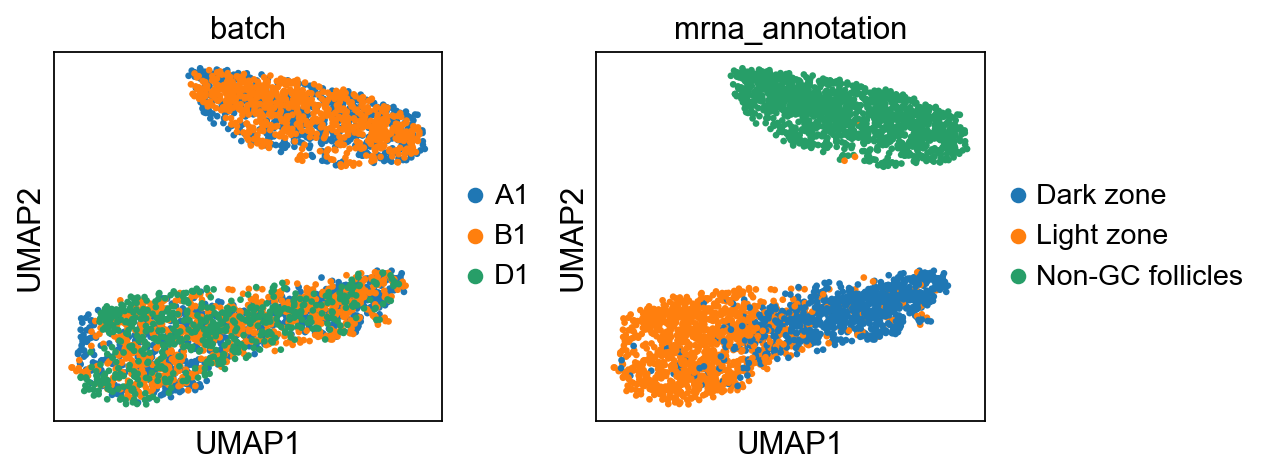

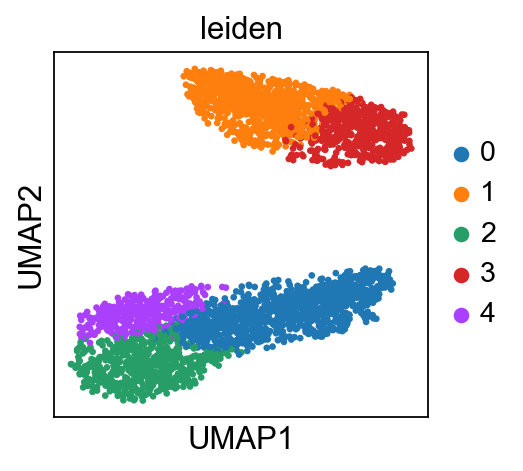

In [217]:
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["batch", "mrna_annotation", ])
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["leiden"])

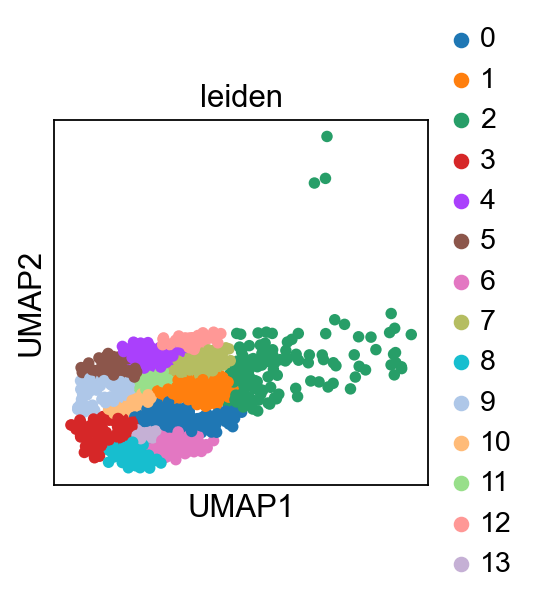

In [218]:
# Step 1: Further cluster only Light zone cells
adata_lz = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] == "Light zone"].copy()
sc.pp.neighbors(adata_lz, use_rep="X_umap")
sc.tl.leiden(adata_lz, resolution=0.5)
sc.pl.umap(adata_lz, color="leiden")




In [219]:
# Extract UMAP coordinates
umap = adata_lz.obsm["X_umap"]

# Identify cells that are in Light zone
target_mask = adata_lz.obs["mrna_annotation"].isin([
    "Light zone"
])

# Further filter: 
exclude_mask = target_mask & (
    ((umap[:, 0] > 8) & (umap[:, 1] > 10))
)

# Create a new AnnData object excluding the undesired cells
adata_lz_filtered = adata_lz[~exclude_mask].copy()

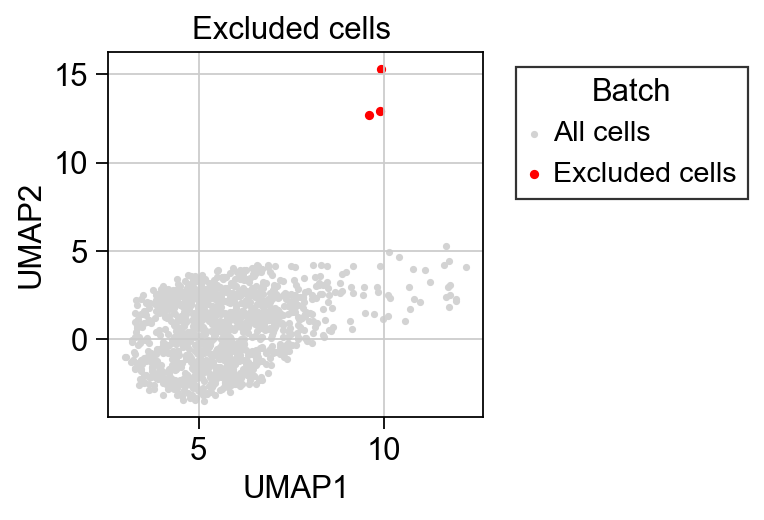

In [220]:
plt.figure(figsize=(3, 3))
plt.scatter(umap[:, 0], umap[:, 1], s=5, c="lightgray", label="All cells")
plt.scatter(umap[exclude_mask, 0], umap[exclude_mask, 1], s=10, c="red", label="Excluded cells")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.title("Excluded cells ")
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [221]:
# Keep all cells that are not in Light zone
keep_other_cells = adata_fraction_oeverlap_gc_follicle.obs[
    ~adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"].isin([
    "Light zone"
    ])
].index
# Cells that passed filtering
keep_filtered_cells = adata_lz_filtered.obs_names
# Combine both sets of cells
combined_index = keep_filtered_cells.union(keep_other_cells)
# Subset the full data to include only the selected cells
adata_fraction_oeverlap_gc_follicle = adata_fraction_oeverlap_gc_follicle[combined_index].copy()

In [222]:
#RNA data
adata_rna_gc_follicle = sc.read("combined_GC_follicle_mRNA_ABD_remove_batch_effect.h5ad")

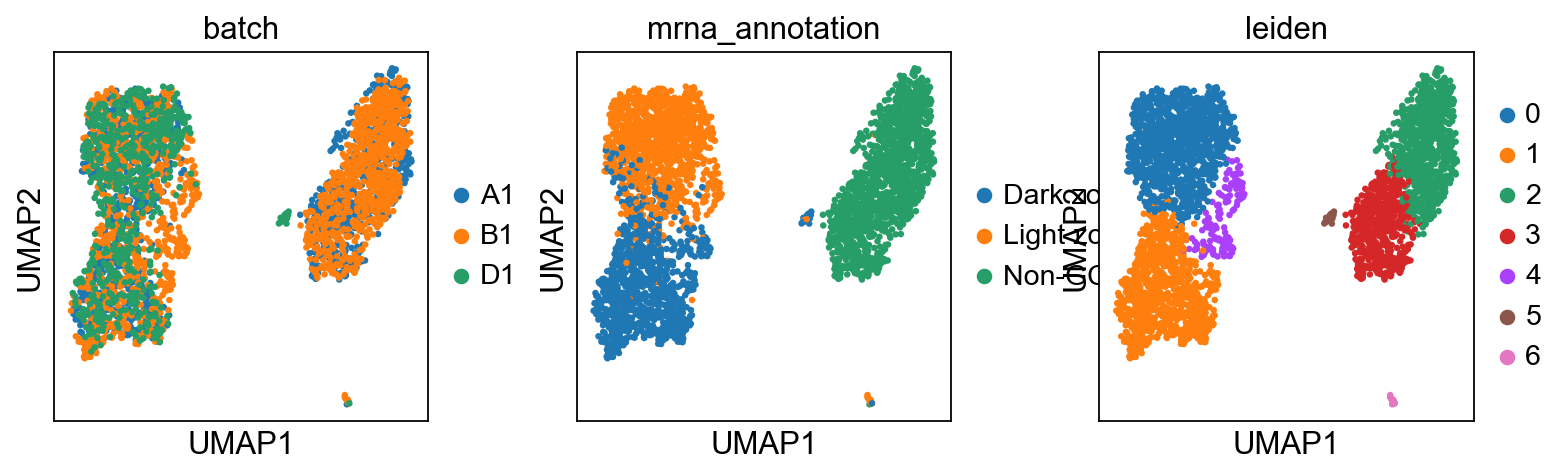

In [223]:
# Leiden clustering to identify substructures
sc.tl.leiden(adata_rna_gc_follicle, resolution=0.5)
sc.pl.umap(adata_rna_gc_follicle, color=["batch", "mrna_annotation", "leiden"])

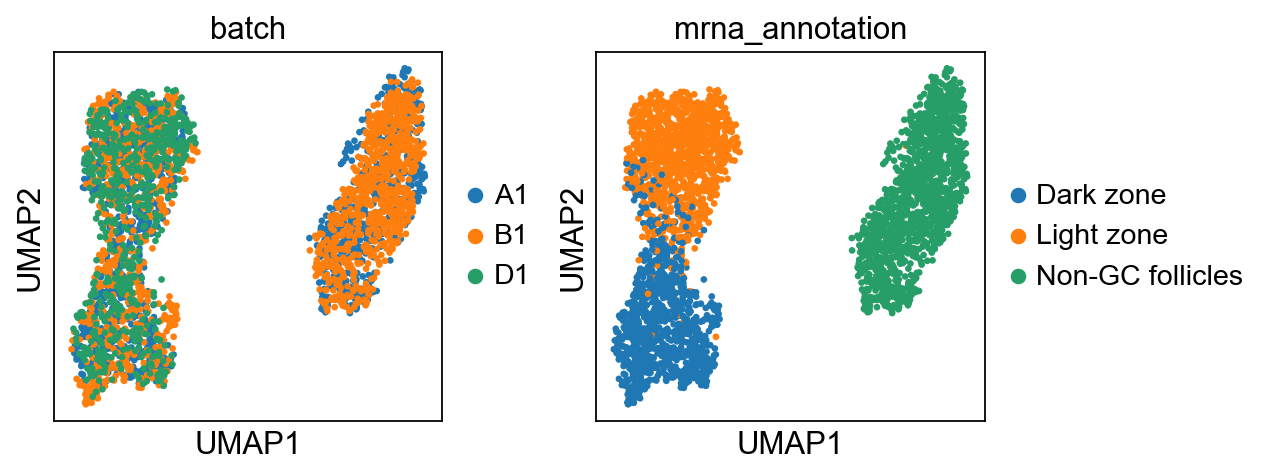

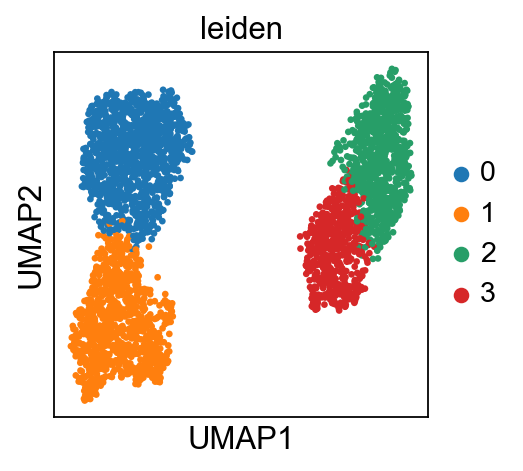

In [224]:
# Optional: filter out Leiden clusters 
main_clusters = ["0", "1", "2", "3", ]
adata_rna_gc_follicle = adata_rna_gc_follicle[
    adata_rna_gc_follicle.obs["leiden"].isin(main_clusters)
].copy()
sc.pl.umap(adata_rna_gc_follicle, color=["batch", "mrna_annotation",])
sc.pl.umap(adata_rna_gc_follicle, color=["leiden"])


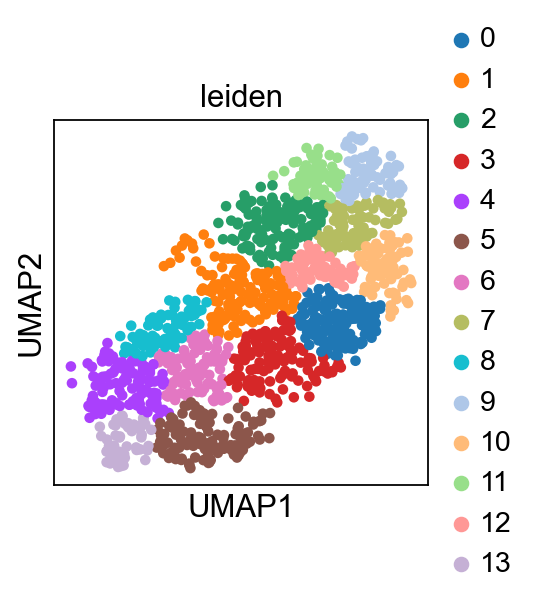

In [225]:
# Step 1: Further cluster Non-GC follicles
adata_rna_pf = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["mrna_annotation"] == "Non-GC follicles"].copy()
sc.pp.neighbors(adata_rna_pf, use_rep="X_umap")
sc.tl.leiden(adata_rna_pf, resolution=0.5)
sc.pl.umap(adata_rna_pf, color="leiden")

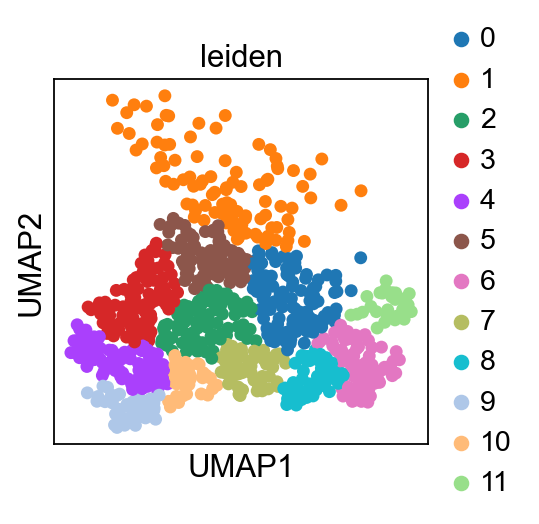

In [226]:
# Step 1: Further cluster Dark zone
adata_rna_dz = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["mrna_annotation"] == "Dark zone"].copy()
sc.pp.neighbors(adata_rna_dz, use_rep="X_umap")
sc.tl.leiden(adata_rna_dz, resolution=0.5)
sc.pl.umap(adata_rna_dz, color="leiden")

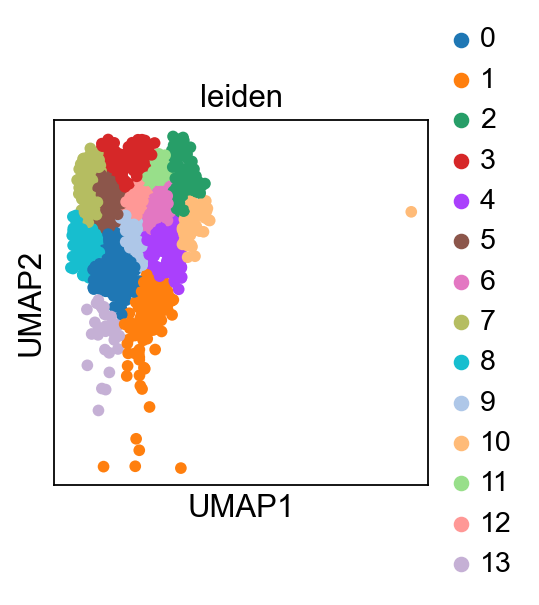

In [227]:
# Step 1: Further cluster only Light zone
adata_rna_lz = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["mrna_annotation"] == "Light zone"].copy()
sc.pp.neighbors(adata_rna_lz, use_rep="X_umap")
sc.tl.leiden(adata_rna_lz, resolution=0.5)
sc.pl.umap(adata_rna_lz, color="leiden")

In [228]:
# Extract UMAP coordinates
umap = adata_rna_lz.obsm["X_umap"]

# Identify cells 
target_mask = adata_rna_lz.obs["mrna_annotation"].isin([
    "Light zone"
])

# Further filter
exclude_mask = target_mask & (
   (umap[:, 1] < 10) | (umap[:, 0] > 10))  


# Create a new AnnData object excluding the undesired cells
adata_rna_lz_filtered = adata_rna_lz[~exclude_mask].copy()

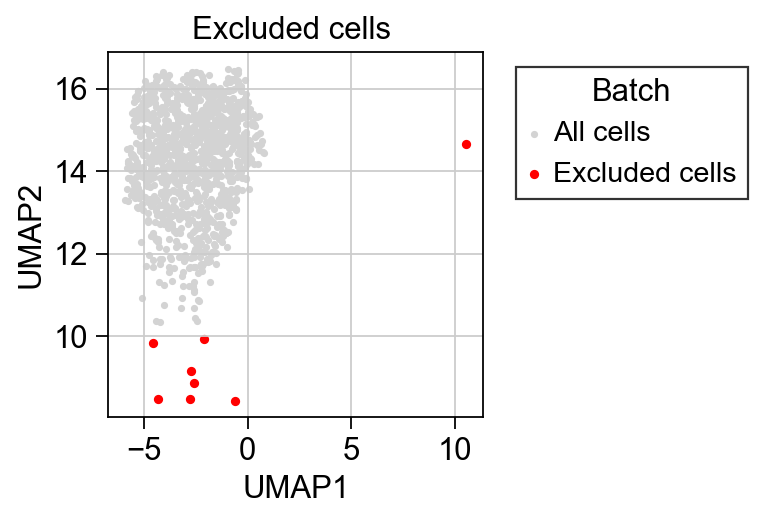

In [229]:
plt.figure(figsize=(3, 3))
plt.scatter(umap[:, 0], umap[:, 1], s=5, c="lightgray", label="All cells")
plt.scatter(umap[exclude_mask, 0], umap[exclude_mask, 1], s=10, c="red", label="Excluded cells")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend()
plt.title("Excluded cells ")
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [230]:
# Keep all cells that are not in Light zone
keep_other_cells = adata_rna_gc_follicle.obs[
    ~adata_rna_gc_follicle.obs["mrna_annotation"].isin([
    "Light zone"
    ])
].index
# Cells that passed filtering 
keep_filtered_cells = adata_rna_lz_filtered.obs_names
# Combine both sets of cells
combined_index = keep_filtered_cells.union(keep_other_cells)
# Subset the full data to include only the selected cells
adata_rna_gc_follicle = adata_rna_gc_follicle[combined_index].copy()

In [231]:
# Get the intersection of cell/barcode IDs (obs_names)
common_obs = adata_rna_gc_follicle.obs_names.intersection(
    adata_fraction_oeverlap_gc_follicle.obs_names
)
print(f"# of common cells: {len(common_obs)}")

# Subset both AnnData objects to the same cells, keeping the order of the first AnnData
adata_rna_gc_follicle   = adata_rna_gc_follicle[common_obs].copy()
adata_fraction_oeverlap_gc_follicle  = adata_fraction_oeverlap_gc_follicle[common_obs].copy()
adata_protein_gc_follicle = adata_protein_gc_follicle[common_obs].copy()
adata_pp_gc_follicle      = adata_pp_gc_follicle[common_obs].copy()


# Step 3: Optional check – make sure all objects now have the same cells
assert (
    adata_rna_gc_follicle.obs_names.equals(common_obs)
    and adata_protein_gc_follicle.obs_names.equals(common_obs)
    and adata_pp_gc_follicle.obs_names.equals(common_obs)
), "Mismatch in obs_names after subsetting!"


# of common cells: 3162


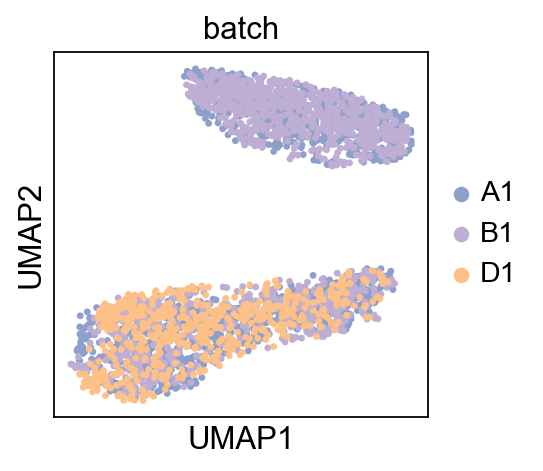

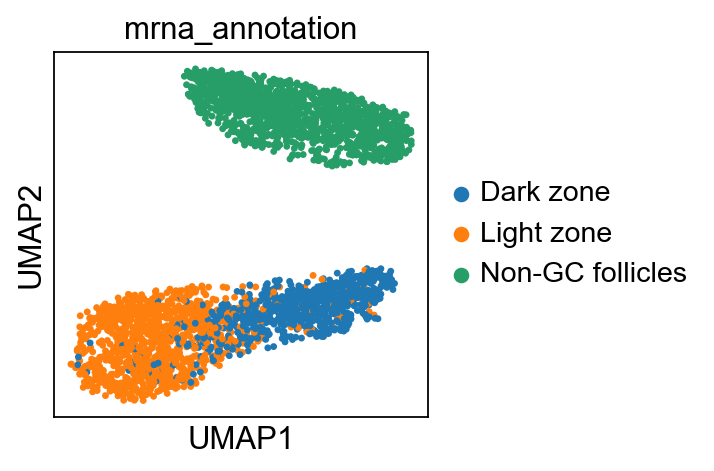

In [232]:
# Define custom palette for 'batch'
batch_palette = ["#8da0cb", "#beaed4", "#fdc086"]

# Option 1: Plot separately
sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color="batch",
    palette=batch_palette,
)

sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color="mrna_annotation",  # keeps default colors
)

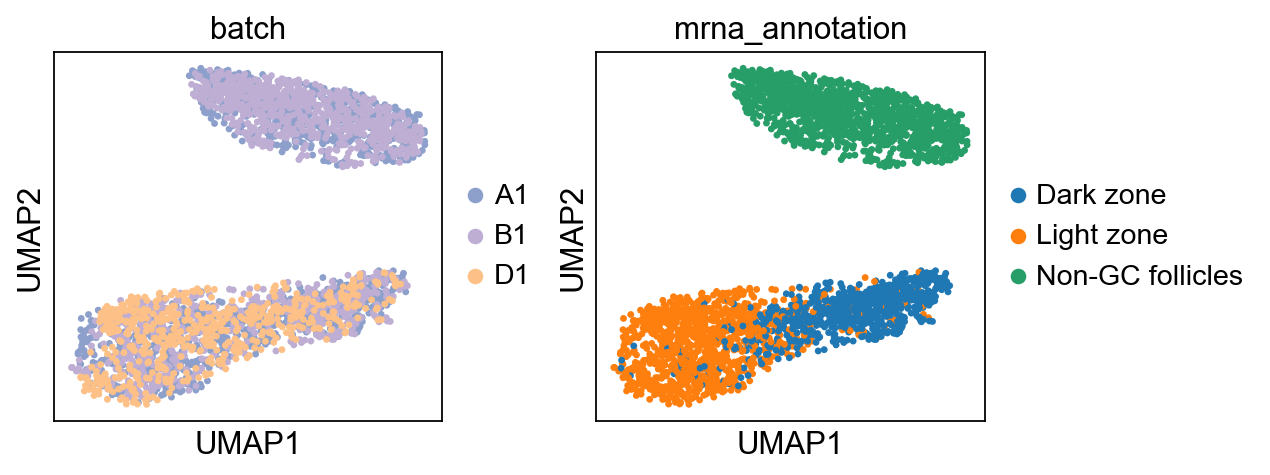

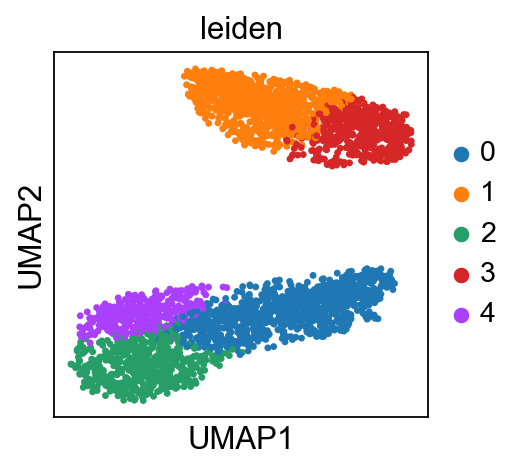

In [156]:
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["batch", "mrna_annotation"], save="Fig-4b-1.svg" )
sc.pl.umap(adata_fraction_oeverlap_gc_follicle, color=["leiden"])

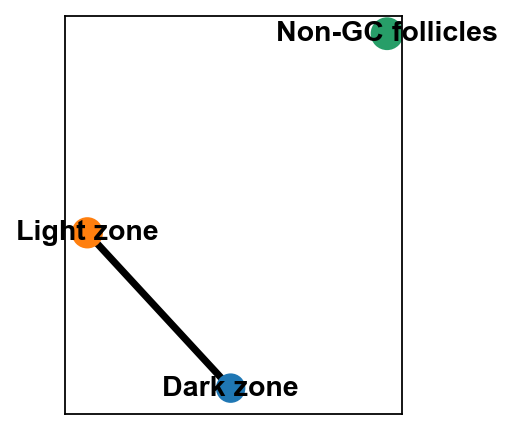

In [157]:
# Step 5: Run PAGA using mrna_annotation
sc.tl.paga(adata_fraction_oeverlap_gc_follicle, "mrna_annotation")
sc.pl.paga(adata_fraction_oeverlap_gc_follicle, threshold=0.05)

# Step 6: Set root cell as one from cleaned Non-GC follicles
early_cells = adata_fraction_oeverlap_gc_follicle.obs[
    adata_fraction_oeverlap_gc_follicle.obs["mrna_annotation"] == "Non-GC follicles"
].index
adata_fraction_oeverlap_gc_follicle.uns["iroot"] = adata_fraction_oeverlap_gc_follicle.obs_names.get_loc(early_cells[0])

# Step 7: Run DPT pseudotime
sc.tl.dpt(adata_fraction_oeverlap_gc_follicle)

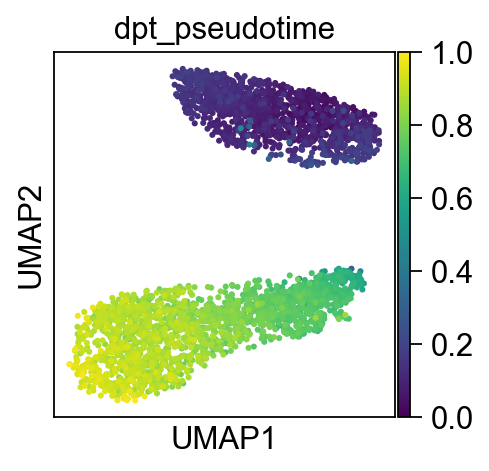

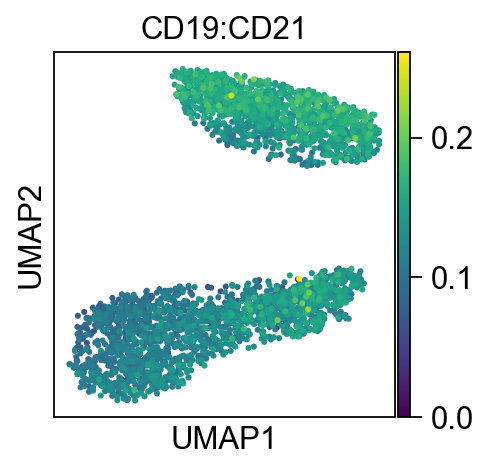

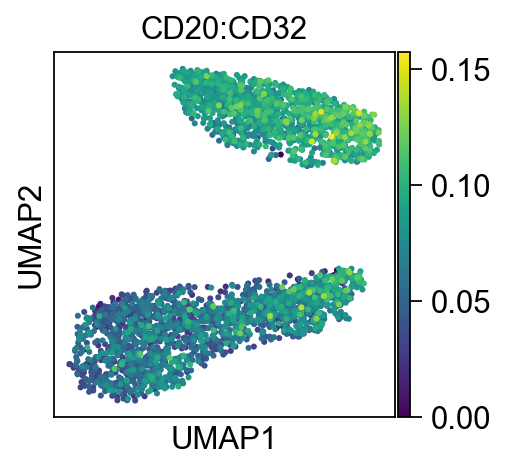

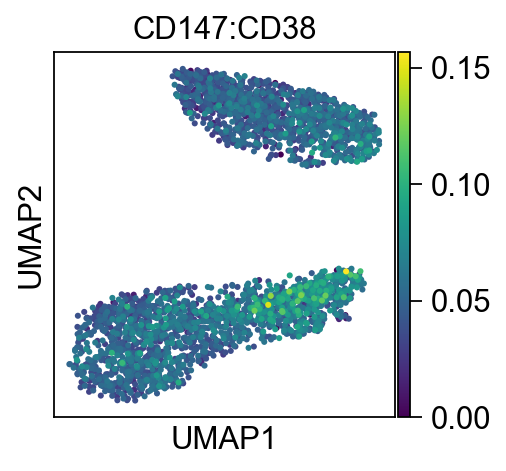

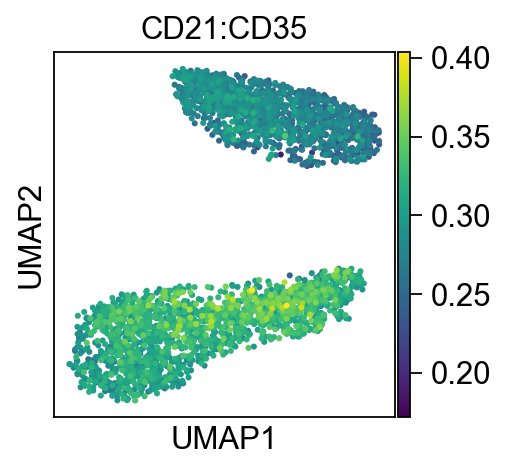

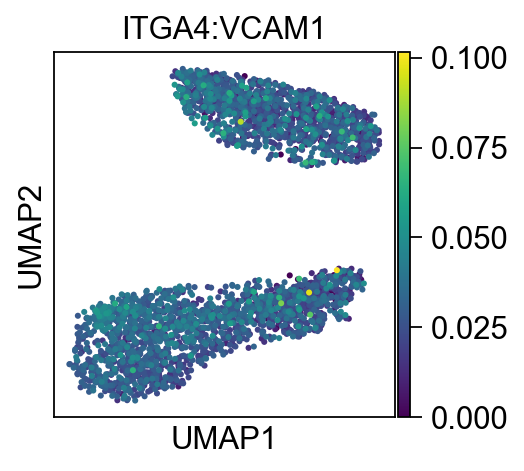

In [158]:
# Step 8: Plot pseudotime
sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color=["dpt_pseudotime", ],
    cmap="viridis",
    size=30,
    save = 'Fig-4b-2.svg',
)
sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color=['CD19:CD21', ],
    cmap="viridis",
    size=30,

)
sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color=['CD20:CD32', ],
    cmap="viridis",
    size=30,
)


sc.pl.umap(
    adata_fraction_oeverlap_gc_follicle,
    color=['CD21:CD35'],
    cmap="viridis",
    size=30,
)




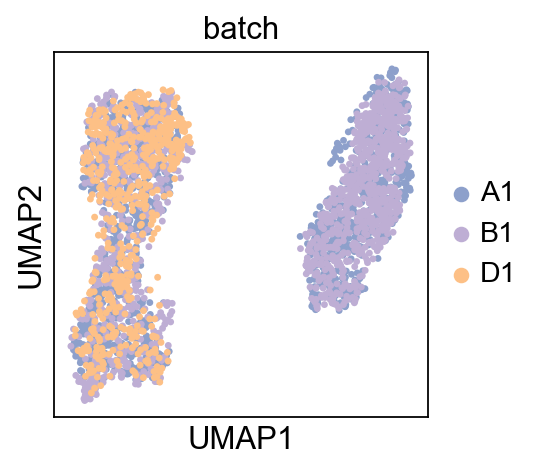

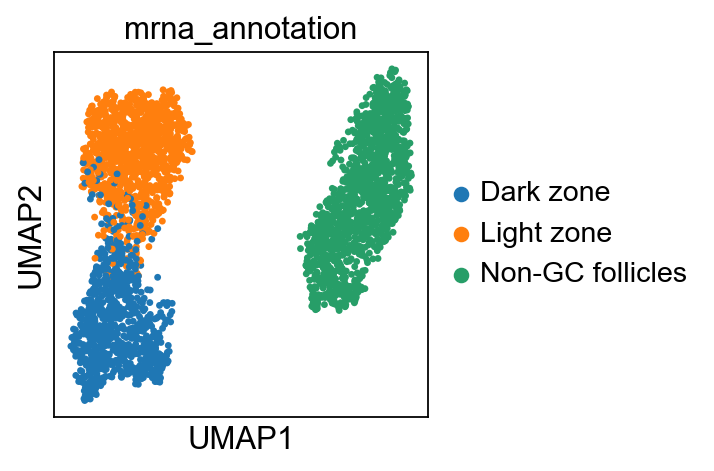

In [159]:
# Define custom palette for 'batch'
batch_palette = ["#8da0cb", "#beaed4", "#fdc086"]

# Option 1: Plot separately
sc.pl.umap(
    adata_rna_gc_follicle,
    color="batch",
    palette=batch_palette,
 
)

sc.pl.umap(
    adata_rna_gc_follicle,
    color="mrna_annotation",  # keeps default colors

)

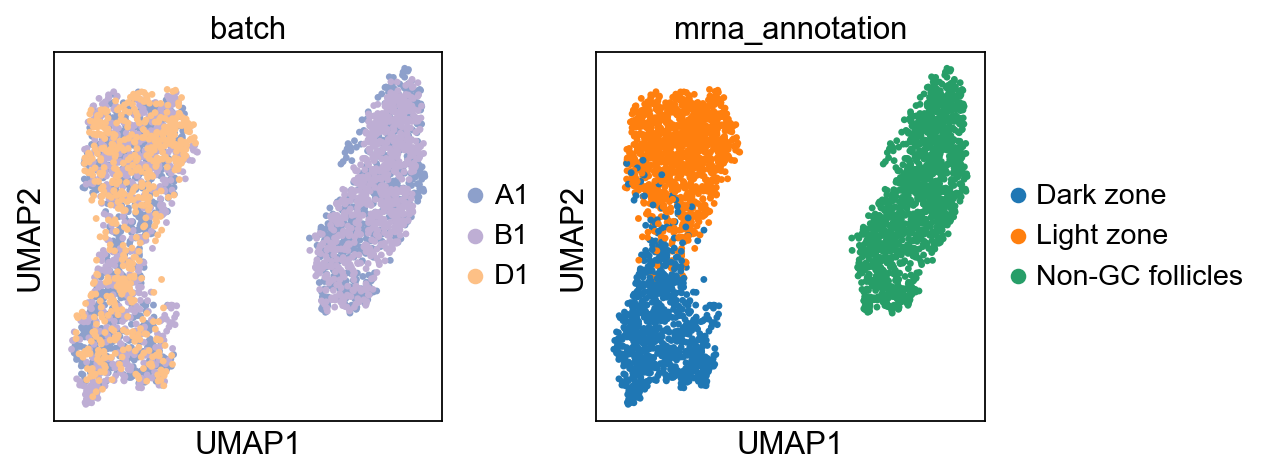

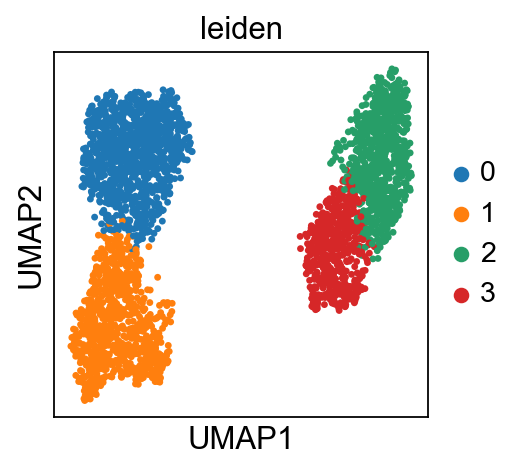

In [160]:
sc.pl.umap(adata_rna_gc_follicle, color=["batch", "mrna_annotation"], save = 'Fig-4a-1.svg')
sc.pl.umap(adata_rna_gc_follicle, color=["leiden"], save = 'Extended-Fig-11b.svg' )

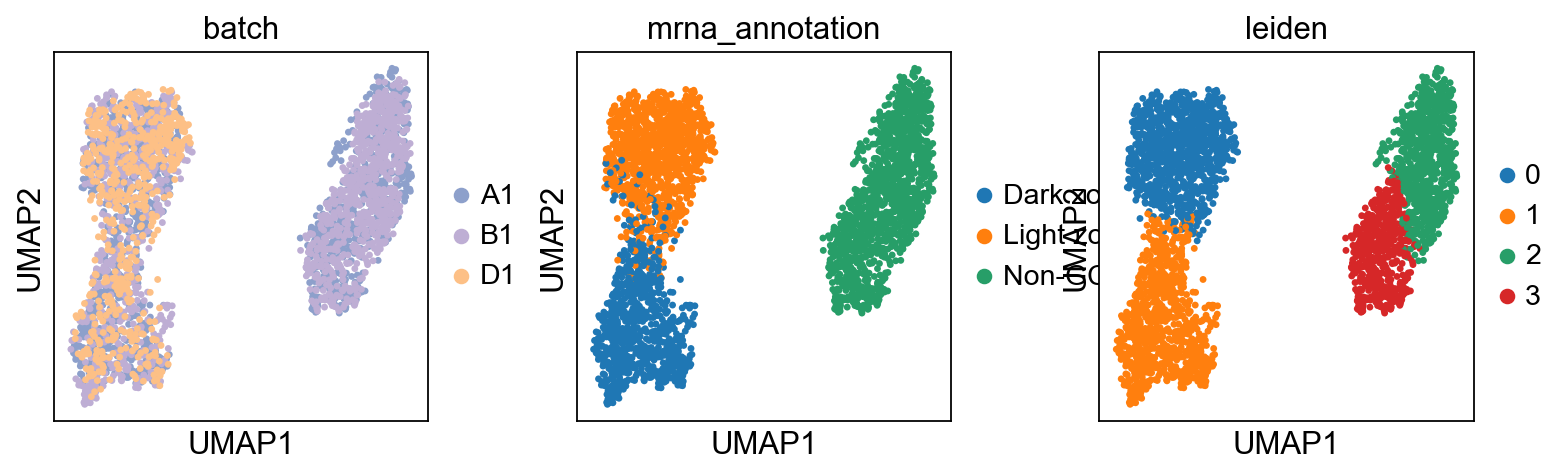

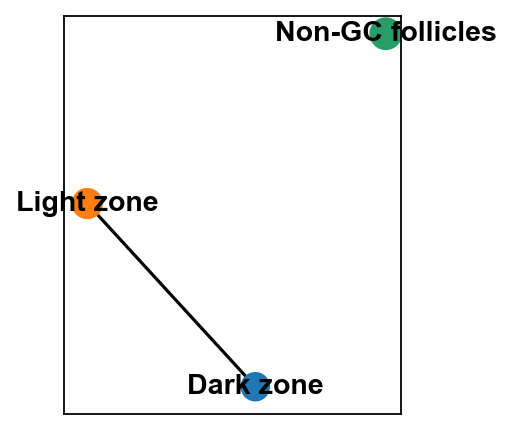

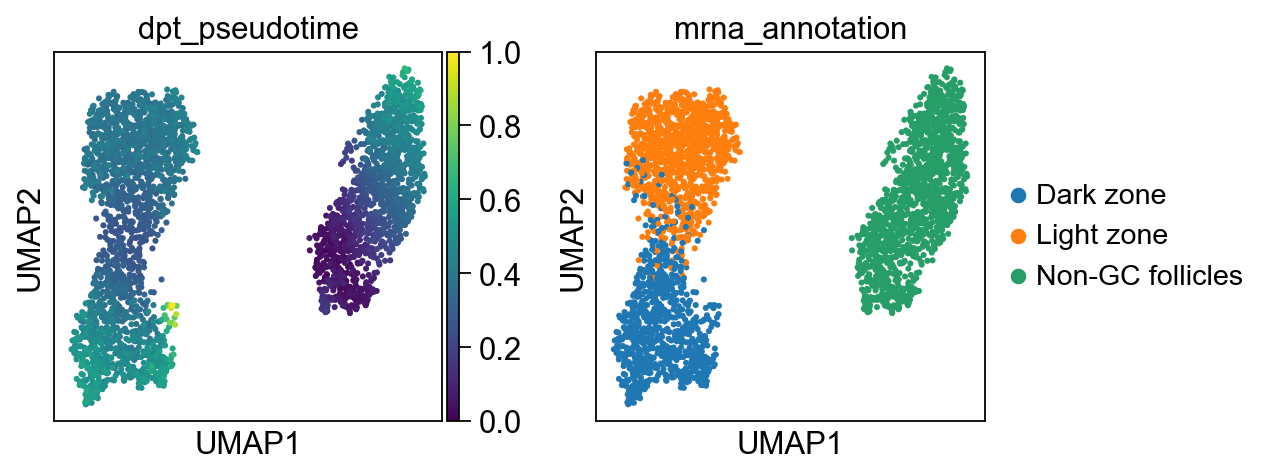

In [161]:
#pseudotime analysis of RNA

sc.tl.leiden(adata_rna_gc_follicle, resolution=0.5)
sc.pl.umap(adata_rna_gc_follicle, color=["batch", "mrna_annotation", "leiden"])
# Use mrna_annotation as group info (do NOT overwrite it via clustering!)
sc.tl.paga(adata_rna_gc_follicle, groups="mrna_annotation")

# Plot the abstract graph
sc.pl.paga(adata_rna_gc_follicle, threshold=0.05, show=True)

# Set root as "Non-GC follicles"
early_cells = adata_rna_gc_follicle.obs[adata_rna_gc_follicle.obs["mrna_annotation"] == "Non-GC follicles"].index  # Adjust based on actual time point labels
adata_rna_gc_follicle.uns["iroot"] = adata_rna_gc_follicle.obs.index.get_loc(early_cells[0])  # Set root cell index

# Run DPT pseudotime
sc.tl.dpt(adata_rna_gc_follicle)

# Plot pseudotime trajectory
sc.pl.umap(
    adata_rna_gc_follicle,
    color=["dpt_pseudotime", "mrna_annotation"],
    cmap="viridis",
    size=30
)



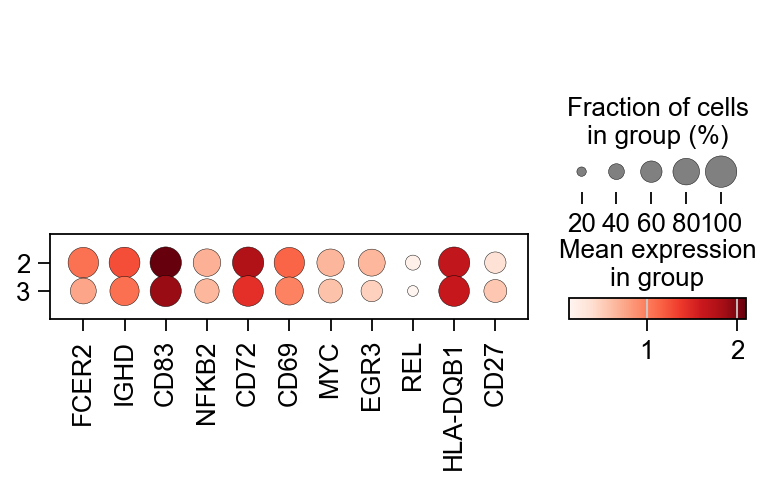

In [163]:
# compare cluster2 and 3
adata_rna_sub = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["leiden"].isin(["2", "3"])].copy()

sc.pl.dotplot(
    adata_rna_sub,
    var_names=['FCER2', 'IGHD', 'CD83', 'NFKB2', 'CD72', 'CD69', 'MYC', 'EGR3', 'REL', 'HLA-DQB1', 'CD27'],
    groupby="leiden",
   save = 'Extended-Fig-11c.svg'
)


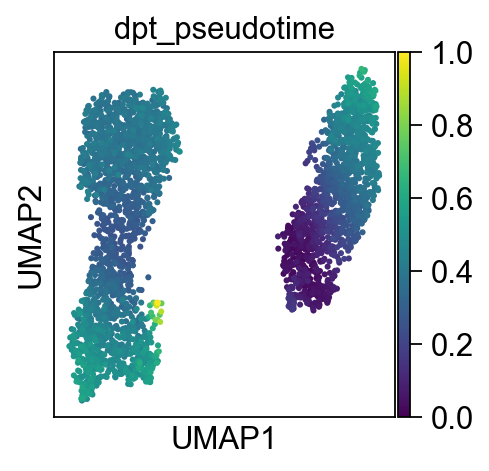

In [164]:
sc.pl.umap(
    adata_rna_gc_follicle,
    color=["dpt_pseudotime",],
    cmap="viridis",
    size=30,
    save = 'Fig-4a-2.svg',
)


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/3784919721.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_rna_gc_follicle_A1, color=['mrna_annotation'], cmap="viridis",library_id="A1", frameon=False, save = 'Fig-4c-1.svg')


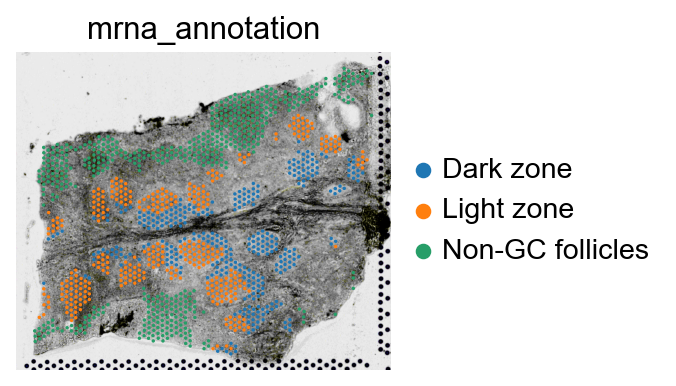

/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/3784919721.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_rna_gc_follicle_A1, color=['dpt_pseudotime'], cmap="viridis",library_id="A1",  frameon=False,save = 'Fig-4c-2.svg')


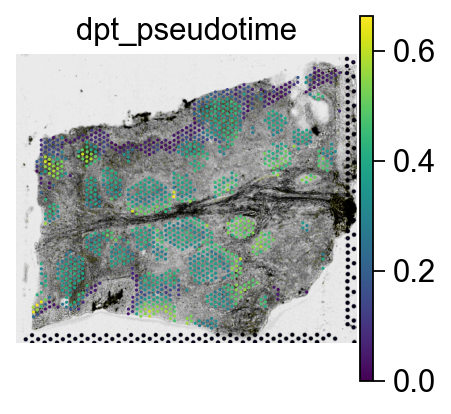

/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/3784919721.py:6: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_fraction_oeverlap_gc_follicle_A1, color=['dpt_pseudotime'], cmap="viridis", library_id="A1", frameon=False, save = 'Fig-4c-3.svg')


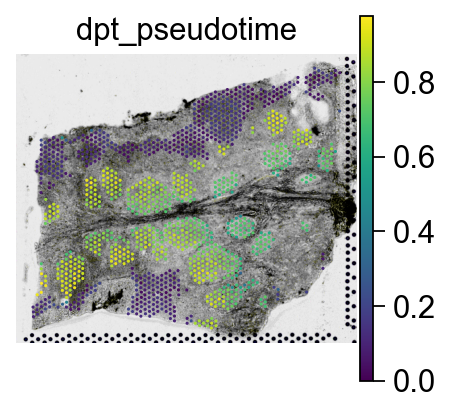

In [165]:
adata_rna_gc_follicle_A1 = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["library_id"] == "A1"].copy()
sc.pl.spatial(adata_rna_gc_follicle_A1, color=['mrna_annotation'], cmap="viridis",library_id="A1", frameon=False, save = 'Fig-4c-1.svg')
sc.pl.spatial(adata_rna_gc_follicle_A1, color=['dpt_pseudotime'], cmap="viridis",library_id="A1",  frameon=False,save = 'Fig-4c-2.svg')

adata_fraction_oeverlap_gc_follicle_A1 = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["library_id"] == "A1"].copy()
sc.pl.spatial(adata_fraction_oeverlap_gc_follicle_A1, color=['dpt_pseudotime'], cmap="viridis", library_id="A1", frameon=False, save = 'Fig-4c-3.svg')


In [166]:
cluster_batch_counts = (
    adata_rna_gc_follicle.obs.groupby(["mrna_annotation", "batch"]).size().unstack(fill_value=0)
)

display(cluster_batch_counts)


batch              A1   B1   D1
mrna_annotation                
Dark zone         337  257  222
Light zone        379  330  341
Non-GC follicles  553  743    0

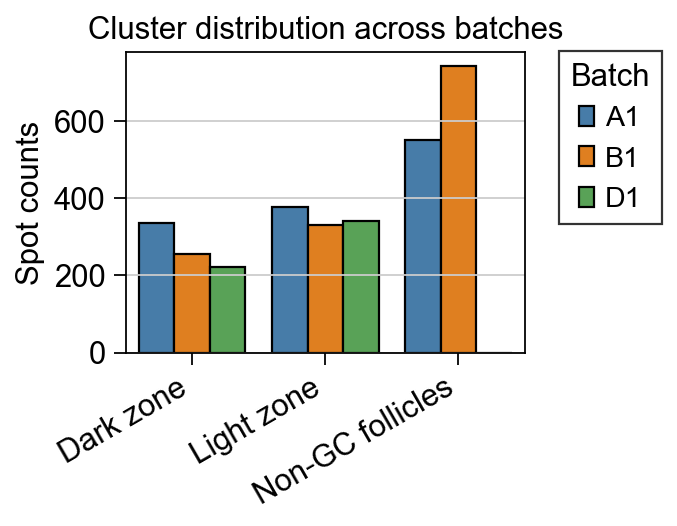

In [167]:

# Define the data
cluster_batch_counts = pd.DataFrame({
    "A1": {"Dark zone": 337, "Light zone": 379, "Non-GC follicles": 553},
    "B1": {"Dark zone": 257, "Light zone": 330, "Non-GC follicles": 743},
    "D1": {"Dark zone": 222, "Light zone": 341, "Non-GC follicles": 0},
})

# Reshape the data for seaborn
df_melted = cluster_batch_counts.reset_index().melt(id_vars="index", var_name="Batch", value_name="Spot count")
df_melted.rename(columns={"index": "Cluster"}, inplace=True)

# Define custom colors for batches
batch_colors = {"A1": "#377eb8", "B1": "#ff7f00", "D1": "#4daf4a"}

# Create the plot
plt.figure(figsize=(4.5, 3.5))
ax = sns.barplot(data=df_melted, x="Cluster", y="Spot count", hue="Batch", palette=batch_colors, edgecolor='black')

# Format axes and labels
plt.ylabel("Spot counts")
plt.xlabel("")
plt.title("Cluster distribution across batches")
plt.xticks(rotation=30, ha='right')

# Move the legend slightly upward
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1.05), loc='upper left')

# Save the figure
os.makedirs("Figures", exist_ok=True)
plt.tight_layout()
plt.savefig("Figures/Extended-Fig-11a.svg", dpi=300, bbox_inches='tight')

plt.show()


In [168]:
adata_fraction_oeverlap_gc_follicle.write("adata_fraction_oeverlap_gc_follicle_for_GSEA.h5ad")

In [169]:
# Step 2: Copy pseudotime column
adata_rna_gc_follicle.obs['dpt_pseudotime'] = adata_fraction_oeverlap_gc_follicle.obs['dpt_pseudotime']
adata_rna_gc_follicle.obs['pseudotime'] = adata_rna_gc_follicle.obs['dpt_pseudotime']

# Step 3: Convert cluster annotations to category
adata_rna_gc_follicle.obs['mrna_annotation'] = adata_rna_gc_follicle.obs['mrna_annotation'].astype('category')

# Step 4: Sort by pseudotime
adata_rna_gc_follicle = adata_rna_gc_follicle[adata_rna_gc_follicle.obs["pseudotime"].argsort()].copy()


In [170]:
# Step 5: Define batch colormap
from matplotlib.colors import ListedColormap
batch_order = ["A1", "B1", "D1"]
batch_color_values = ["#8c8cff", "#b377d6", "#d4a373"]
batch_cmap = ListedColormap(batch_color_values)

In [171]:
# Step 6: Make sure batch is categorical and ordered
adata_rna_gc_follicle.obs["batch"] = adata_rna_gc_follicle.obs["batch"].astype("category")
adata_rna_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)
adata_rna_gc_follicle.uns["batch_colors"] = batch_color_values


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/1613953199.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_rna_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)


/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


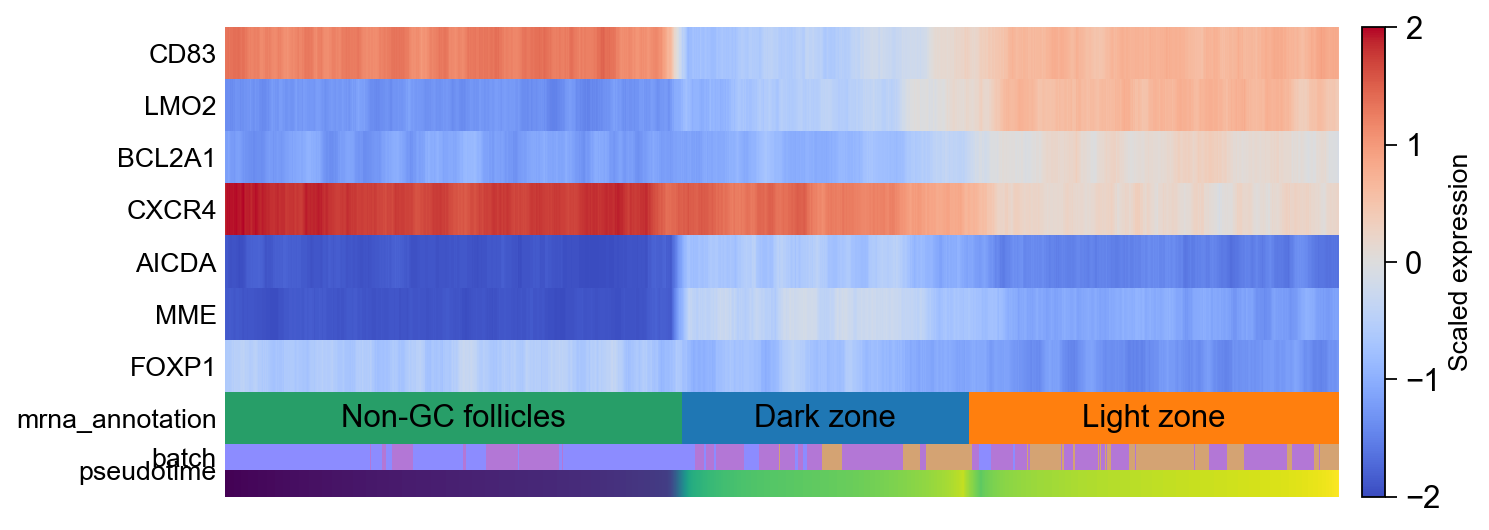

In [172]:
marker_genes = ['CD83', 'LMO2', 'BCL2A1', 'CXCR4', 'AICDA', 'MME', 'FOXP1']
plt.figure(figsize=(9, 3))
sc.pl.paga_path(
    adata_rna_gc_follicle,
    keys=marker_genes,
    nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=["pseudotime", "batch"],
    show_colorbar=False,
    color_map="coolwarm",
    groups_key="mrna_annotation",
    color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
    use_raw=True,
    return_data=False,
    show=False
)

# Step 8: Add expression colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
cmap = plt.get_cmap("coolwarm")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Scaled expression", fontsize=12)

plt.show()


In [173]:
A1_B1_D1_pla_pair_pass_fisher_test = pd.read_csv('A1_B1_D1_pla_pair_pass_fisher_test_0.15_B_cell_cluster.csv',)
A1_B1_D1_pla_pair_pass_fisher_test.set_index("type", inplace=True)

In [174]:
# Extract the list of protein pairs from the selected dimer types
protein_pairs = A1_B1_D1_pla_pair_pass_fisher_test.loc[
    ["Heterodimer"], "protein_pair"
]

# Find which pairs are missing from the AnnData variable names
missing_pairs = protein_pairs[~protein_pairs.isin(adata_fraction_oeverlap_gc_follicle.var.index)]

# Print missing protein pairs
print("Protein pairs missing in AnnData:")
print(missing_pairs.tolist())


Protein pairs missing in AnnData:
[]


In [175]:
# Step 2: Copy pseudotime column
adata_fraction_oeverlap_gc_follicle.obs['pseudotime'] = adata_fraction_oeverlap_gc_follicle.obs['dpt_pseudotime']

# Step 3: Convert cluster annotations to category
adata_fraction_oeverlap_gc_follicle.obs['mrna_annotation'] = adata_fraction_oeverlap_gc_follicle.obs['mrna_annotation'].astype('category')

# Step 4: Sort by pseudotime
adata_fraction_oeverlap_gc_follicle = adata_fraction_oeverlap_gc_follicle[adata_fraction_oeverlap_gc_follicle.obs["pseudotime"].argsort()].copy()

In [176]:
# Step 6: Make sure batch is categorical and ordered
adata_fraction_oeverlap_gc_follicle.obs["batch"] = adata_fraction_oeverlap_gc_follicle.obs["batch"].astype("category")
adata_fraction_oeverlap_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)
adata_fraction_oeverlap_gc_follicle.uns["batch_colors"] = batch_color_values


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/1525165791.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_fraction_oeverlap_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)


/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


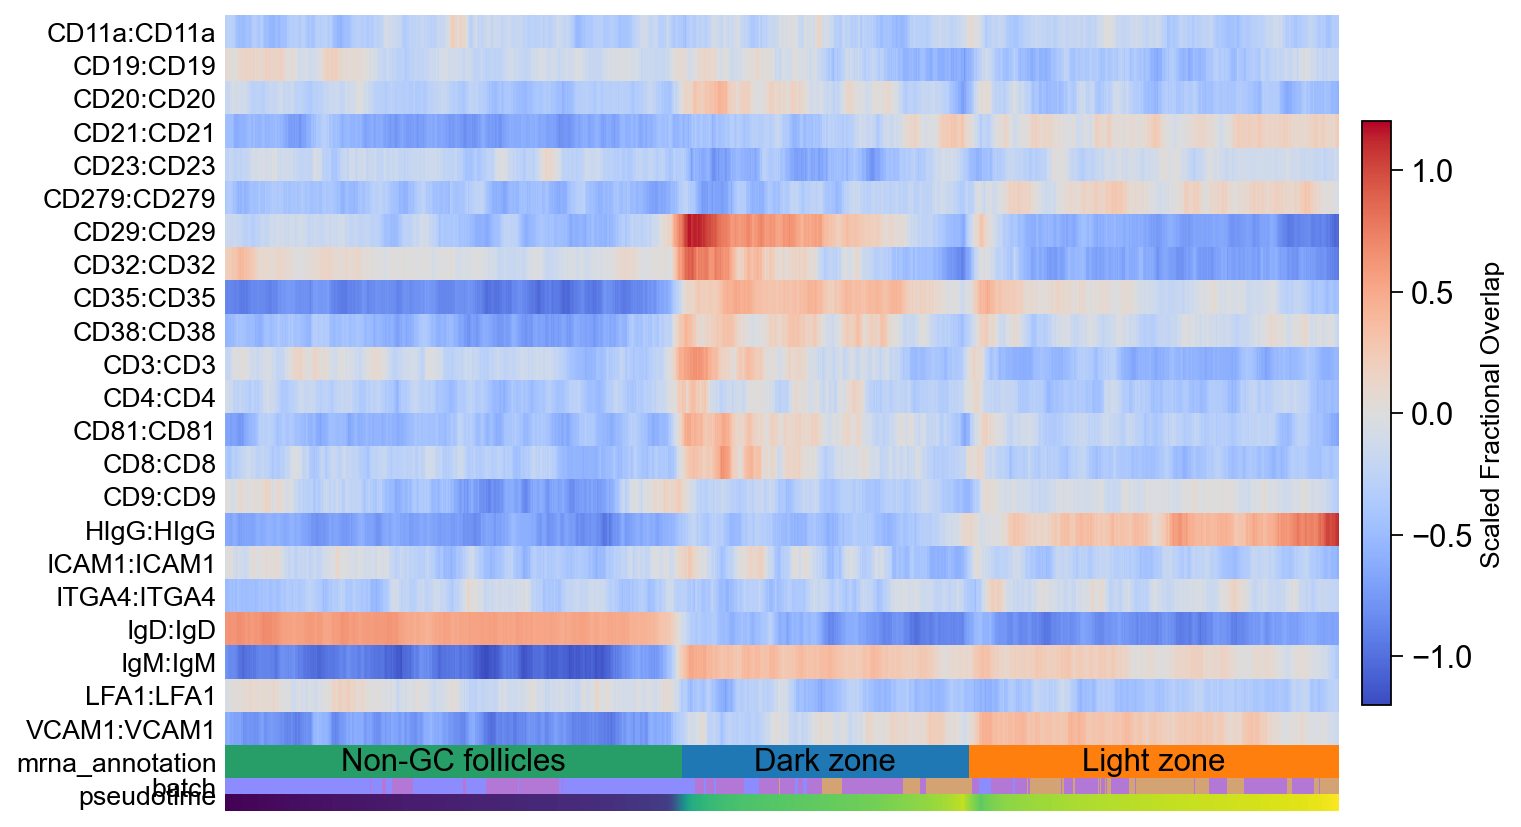

In [177]:
plt.figure(figsize=(9, 6))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= A1_B1_D1_pla_pair_pass_fisher_test.loc["Homodimer", "protein_pair"],
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=["pseudotime", "batch"],
    show_colorbar=False,
    color_map="coolwarm",
    groups_key="mrna_annotation",
    color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
    use_raw=False,
    return_data=False,
    show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-1.2, vmax=1.2)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("coolwarm")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Scaled Fractional Overlap", fontsize=12)

plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


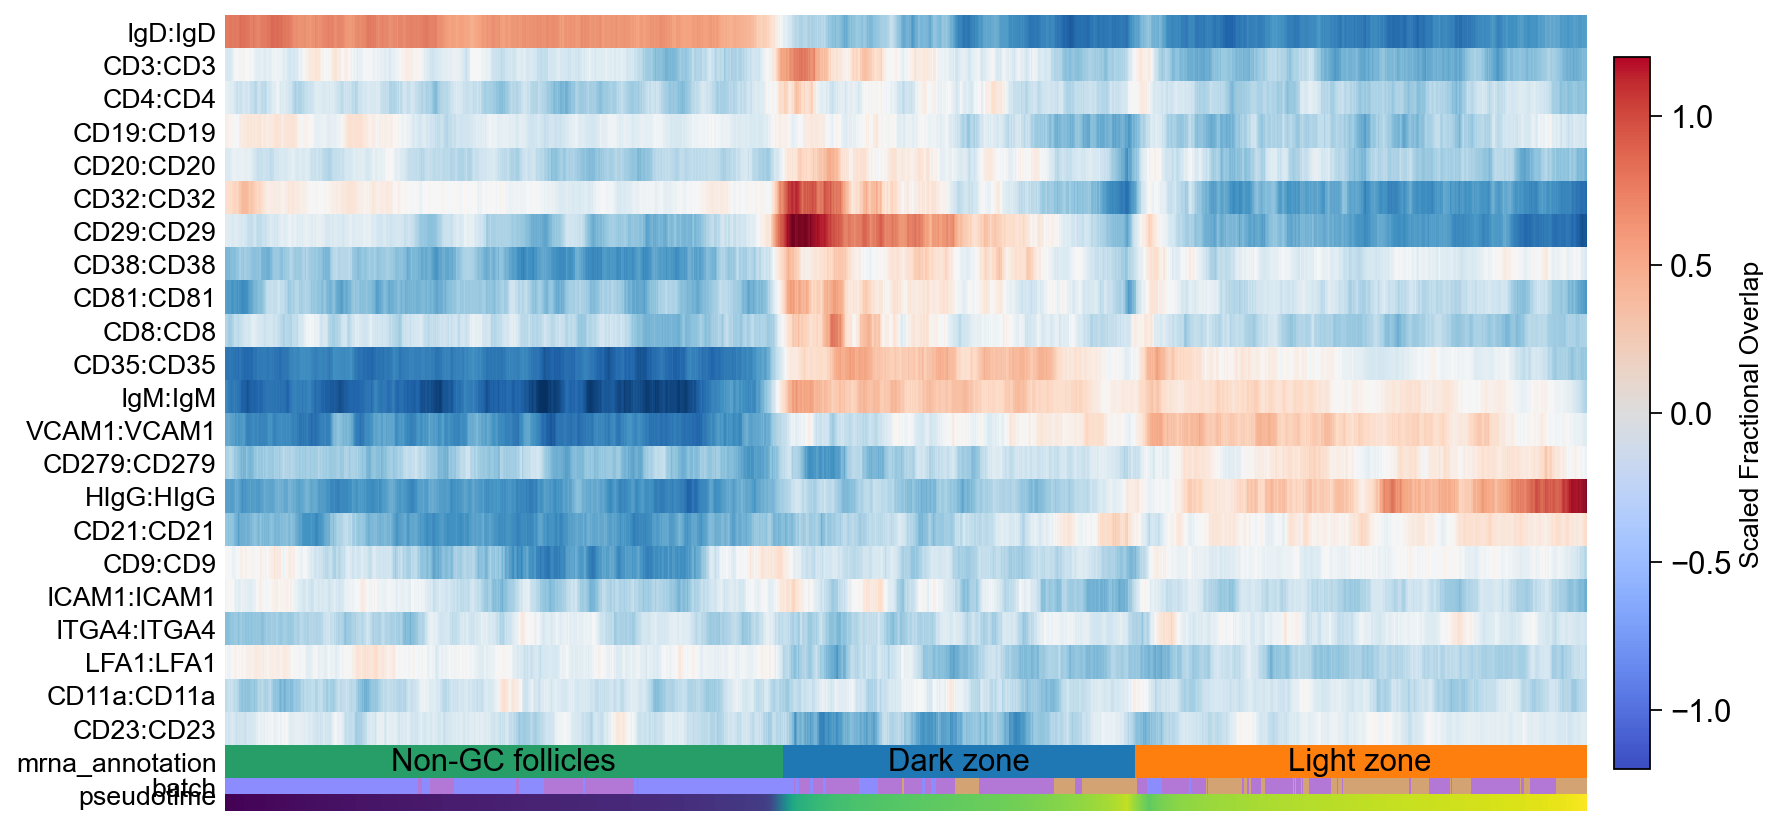

In [178]:
Homodimer_order = [
    "IgD:IgD","CD3:CD3",
    "CD4:CD4",  "CD19:CD19", "CD20:CD20",  "CD32:CD32", "CD29:CD29", "CD38:CD38", "CD81:CD81", "CD8:CD8","CD35:CD35", "IgM:IgM", 
    "VCAM1:VCAM1","CD279:CD279","HIgG:HIgG","CD21:CD21", "CD9:CD9", "ICAM1:ICAM1", 
    "ITGA4:ITGA4", "LFA1:LFA1", "CD11a:CD11a", "CD23:CD23",
]

plt.figure(figsize=(11, 6))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= Homodimer_order,
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime", "batch"],
        show_colorbar=False,
        color_map="RdBu_r",
        groups_key="mrna_annotation",
        color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
    use_raw=False,
    return_data=False,
    show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-1.2, vmax=1.2)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("coolwarm")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Scaled Fractional Overlap", fontsize=12)
plt.savefig("Figures/paga_path_fractional_overlap_homodimer.png", dpi=300)
plt.savefig("Figures/paga_path_fractional_overlap_homodimer.svg", dpi=300)

plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


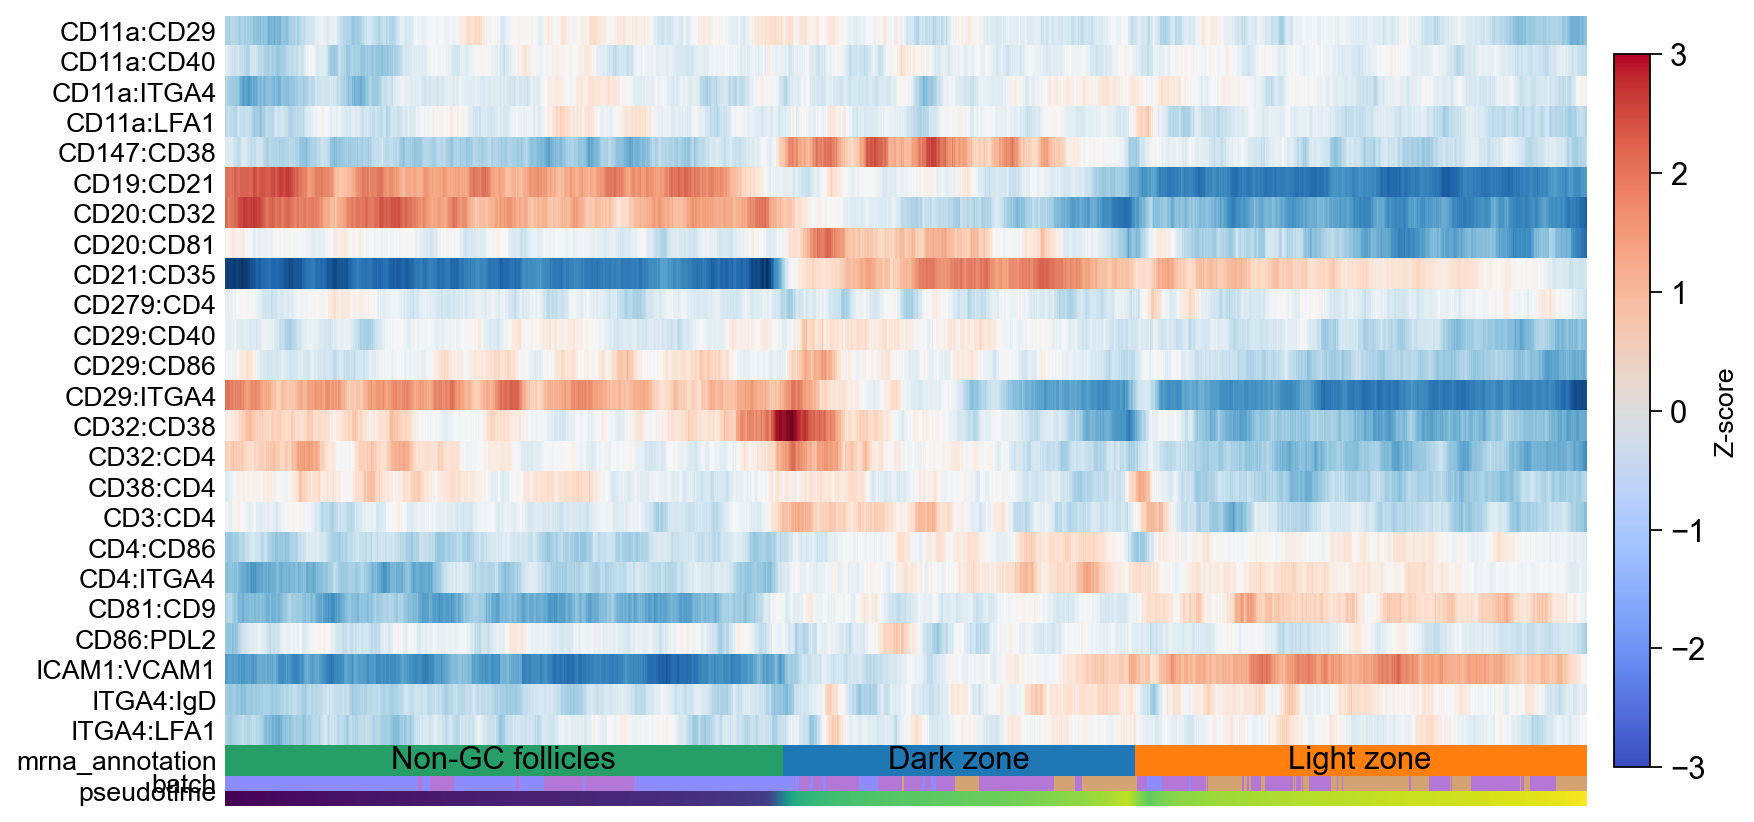

In [179]:
plt.figure(figsize=(11, 6))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= A1_B1_D1_pla_pair_pass_fisher_test.loc["Heterodimer", "protein_pair"],
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime", "batch"],
        show_colorbar=False,
        color_map="RdBu_r",
        groups_key="mrna_annotation",
        color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
        use_raw=False,
        return_data=False,
        show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-3, vmax=3)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("coolwarm")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Z-score", fontsize=12)


plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


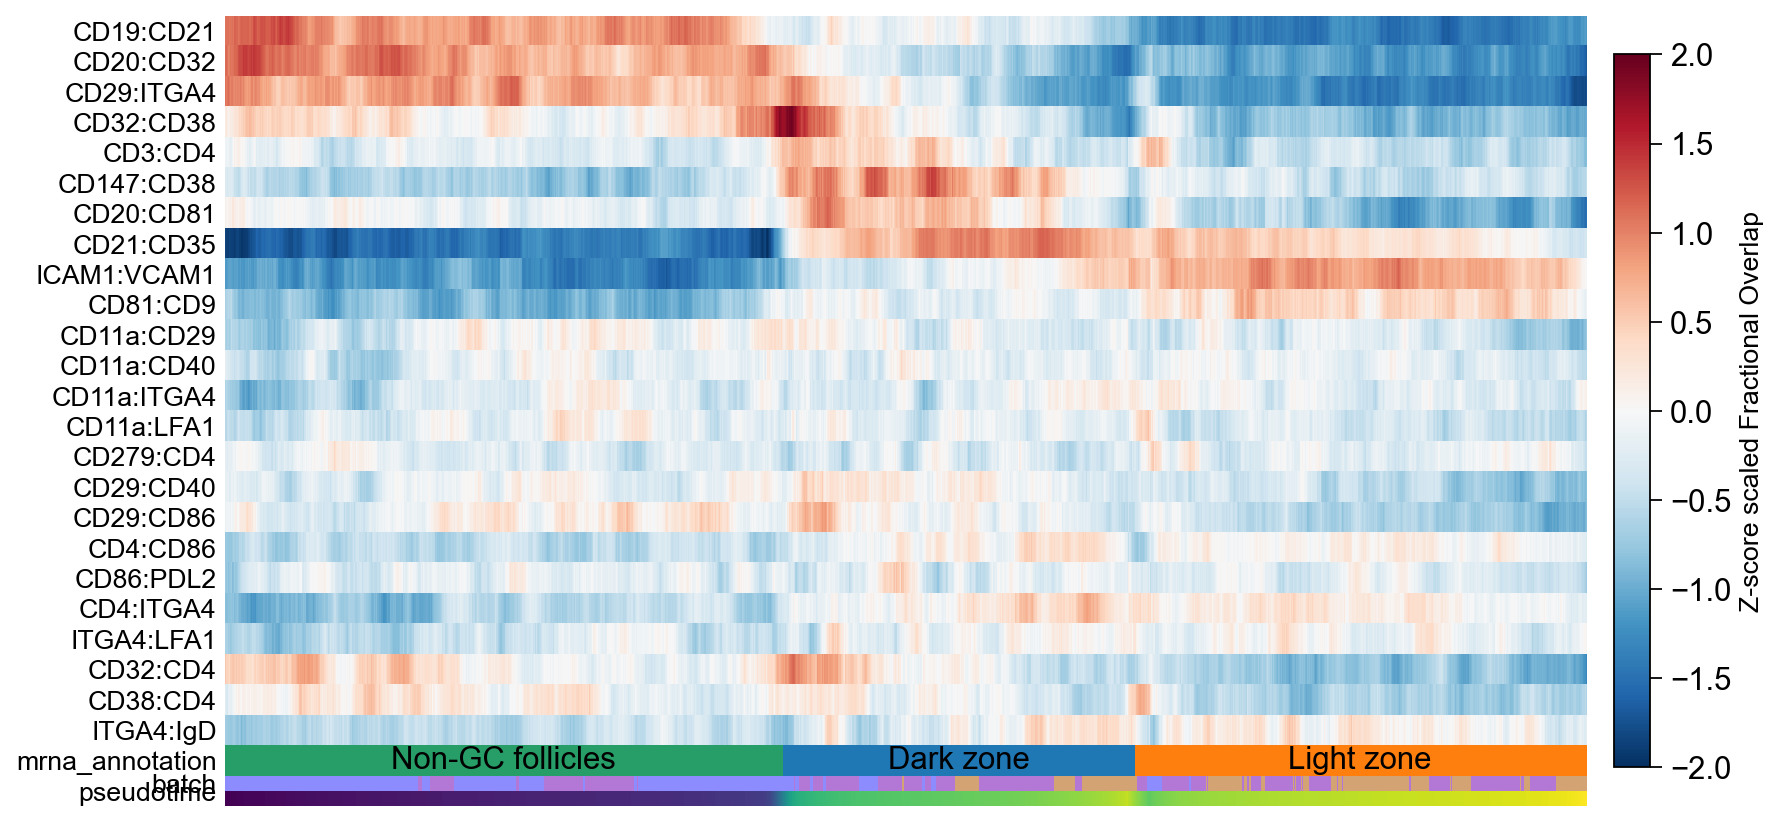

In [180]:
Heterodimer_order = [
     "CD19:CD21",'CD20:CD32',"CD29:ITGA4", 'CD32:CD38',"CD3:CD4",'CD147:CD38',"CD20:CD81","CD21:CD35",
    "ICAM1:VCAM1", "CD81:CD9", 'CD11a:CD29','CD11a:CD40','CD11a:ITGA4','CD11a:LFA1','CD279:CD4',
'CD29:CD40','CD29:CD86','CD4:CD86','CD86:PDL2',"CD4:ITGA4",'ITGA4:LFA1','CD32:CD4','CD38:CD4','ITGA4:IgD']
plt.figure(figsize=(11, 6))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= Heterodimer_order,
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime", "batch"],
        show_colorbar=False,
        color_map="RdBu_r",
        groups_key="mrna_annotation",
        color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
        use_raw=False,
        return_data=False,
        show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-2, vmax=2)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("RdBu_r")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Z-score scaled Fractional Overlap", fontsize=12)
plt.savefig("Figures/paga_path_fractional_overlap.png", dpi=300)
plt.savefig("Figures/paga_path_fractional_overlap.svg", dpi=300)
plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


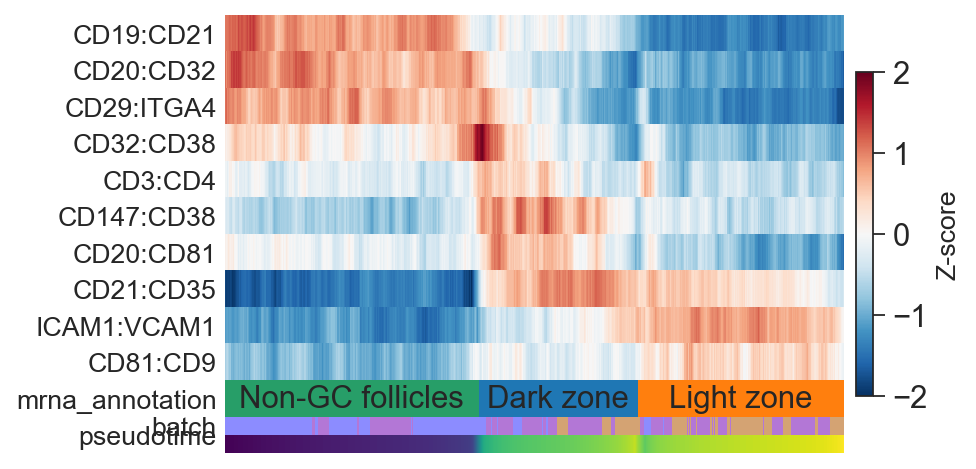

In [206]:
Heterodimer_order = [
     "CD19:CD21",'CD20:CD32',"CD29:ITGA4", 'CD32:CD38',"CD3:CD4",'CD147:CD38',"CD20:CD81","CD21:CD35",
    "ICAM1:VCAM1", "CD81:CD9", ]
plt.figure(figsize=(5, 3))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= Heterodimer_order,
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime", "batch"],
        show_colorbar=False,
        color_map="RdBu_r",
        groups_key="mrna_annotation",
        color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
        use_raw=False,
        return_data=False,
        show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-2, vmax=2)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("RdBu_r")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Z-score", fontsize=12)
plt.savefig("Figures/Fig-4e.svg", dpi=300)
plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


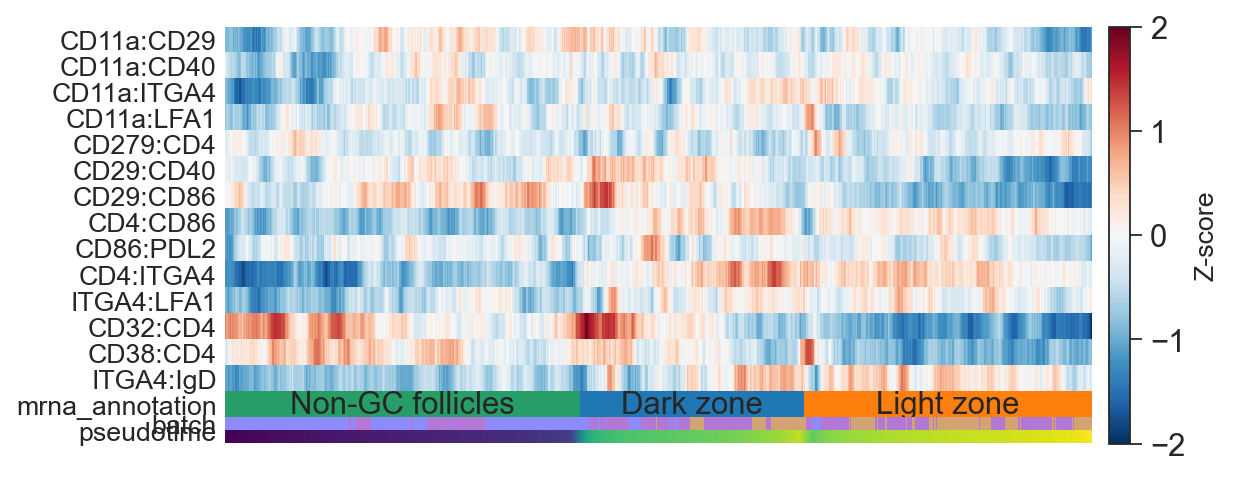

In [203]:
Heterodimer_order = ['CD11a:CD29','CD11a:CD40','CD11a:ITGA4','CD11a:LFA1','CD279:CD4',
'CD29:CD40','CD29:CD86','CD4:CD86','CD86:PDL2',"CD4:ITGA4",'ITGA4:LFA1','CD32:CD4','CD38:CD4','ITGA4:IgD' ]
plt.figure(figsize=(7, 3))
sc.pl.paga_path(
        adata_fraction_oeverlap_gc_follicle,
        keys= Heterodimer_order,
        nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime", "batch"],
        show_colorbar=False,
        color_map="RdBu_r",
        groups_key="mrna_annotation",
        color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
        use_raw=False,
        return_data=False,
        show=False
)
# Manually add custom colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-2, vmax=2)   # Adjust vmin/vmax if needed
cmap = plt.get_cmap("RdBu_r")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to figure with custom label
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Z-score", fontsize=12)
plt.savefig("Figures/Extended-Fig-11e.svg", dpi=300)
plt.show()

In [183]:
# Copy 'mrna_annotation' to a new column 'cluster'
cols_to_copy = ['mrna_annotation', 'dpt_pseudotime']
adata_protein_gc_follicle.obs[cols_to_copy] = adata_fraction_oeverlap_gc_follicle.obs[cols_to_copy]


In [184]:
# Step 2: Copy pseudotime column
adata_protein_gc_follicle.obs['dpt_pseudotime'] = adata_fraction_oeverlap_gc_follicle.obs['dpt_pseudotime']
adata_protein_gc_follicle.obs['pseudotime'] = adata_protein_gc_follicle.obs['dpt_pseudotime']

# Step 3: Convert cluster annotations to category
adata_protein_gc_follicle.obs['mrna_annotation'] = adata_protein_gc_follicle.obs['mrna_annotation'].astype('category')

# Step 4: Sort by pseudotime
adata_protein_gc_follicle = adata_protein_gc_follicle[adata_protein_gc_follicle.obs["pseudotime"].argsort()].copy()
# Step 6: Make sure batch is categorical and ordered
adata_protein_gc_follicle.obs["batch"] = adata_protein_gc_follicle.obs["batch"].astype("category")
adata_protein_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)
adata_protein_gc_follicle.uns["batch_colors"] = batch_color_values


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/631222599.py:12: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_protein_gc_follicle.obs["batch"].cat.set_categories(batch_order, inplace=True)


/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


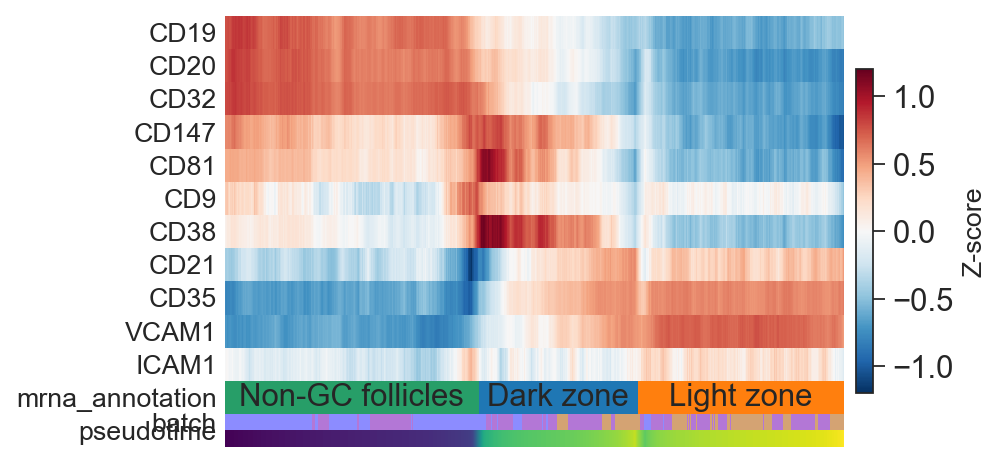

In [205]:
# Select markers and prepare pseudotime
proteins= [ 'CD19',   'CD20',   'CD32', 'CD147','CD81', 'CD9','CD38','CD21', 'CD35',   'VCAM1','ICAM1',]
# Use pseudotime information from DPT
adata_protein_gc_follicle.obs["pseudotime"] = adata_protein_gc_follicle.obs["dpt_pseudotime"]

# Plot the expression along pseudotime using paga_path (without default colorbar)
plt.figure(figsize=(5, 3))
sc.pl.paga_path(
    adata_protein_gc_follicle,
    keys=proteins,
    nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=["pseudotime", "batch"],
    show_colorbar=False,
    color_map="RdBu_r",
    groups_key="mrna_annotation",
    color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
    use_raw=False,
    return_data=False,
    show=False
)

# Get the current figure generated by Scanpy
fig = plt.gcf()

# Manually add a colorbar to match your scaling
norm = mpl.colors.Normalize(vmin=-1.2, vmax=1.2)
cmap = plt.get_cmap("RdBu_r")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Attach the colorbar to the figure
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
cbar.set_label("Z-score", fontsize=12)

# Save the figure to file
fig.savefig("figures/Fig-4f.svg", dpi=300, bbox_inches='tight')

# Optional: Display the plot (for Jupyter or interactive use)
plt.show()

/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1292: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(["", xlabel, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)
/Users/huiliw/anaconda3/envs/scanpy_proxseq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1334: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(["", anno, ""], fontsize=ytick_fontsize)


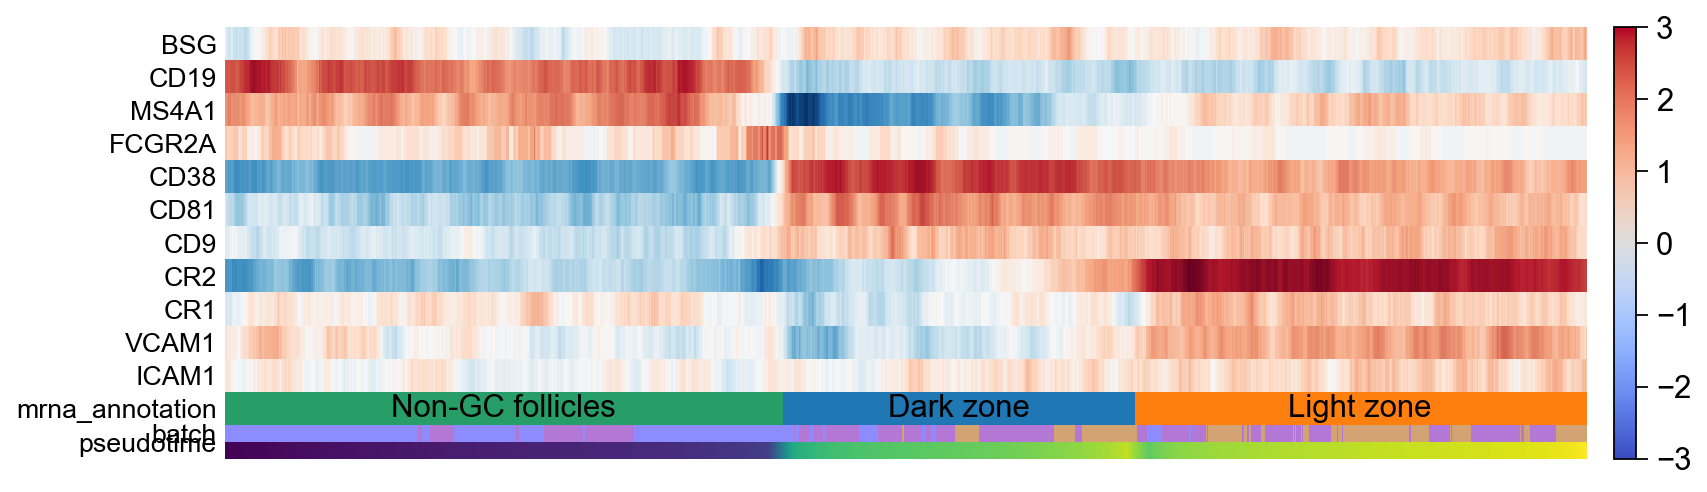

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

# Step 1: Define genes
genes = ['BSG', 'CD19', 'MS4A1', 'FCGR2A', 'CD38', 'CD81', 'CD9', 'CR2', 'CR1', 'VCAM1', 'ICAM1']


# Step 2: Add pseudotime from DPT
adata_rna_gc_follicle.obs["pseudotime"] = adata_rna_gc_follicle.obs["dpt_pseudotime"]

# Step 3: Extract from raw and z-score manually
raw_expr = pd.DataFrame(
    adata_rna_gc_follicle.raw[:, genes].X.toarray(),
    index=adata_rna_gc_follicle.obs_names,
    columns=genes
)
scaled_expr = pd.DataFrame(
    StandardScaler().fit_transform(raw_expr),
    index=raw_expr.index,
    columns=genes
)

# Step 4: Put scaled values back into adata.obs with original gene names
for gene in genes:
    adata_rna_gc_follicle.obs[gene] = scaled_expr[gene]

# Step 5: Plot using Scanpy paga_path
plt.figure(figsize=(11, 3))
sc.pl.paga_path(
    adata_rna_gc_follicle,
    keys=genes,
    nodes=['Non-GC follicles', 'Dark zone', 'Light zone'],
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=["pseudotime", "batch"],
    show_colorbar=False,
    color_map="RdBu_r",
    groups_key="mrna_annotation",
    color_maps_annotations={
        "pseudotime": "viridis",
        "batch": batch_cmap
    },
    use_raw=False,
    return_data=False,
    show=False
)

# Step 6: Add colorbar
fig = plt.gcf()
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
cmap = plt.get_cmap("coolwarm")
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=fig.get_axes(), fraction=0.025, pad=0.02)
# cbar.set_label("Scaled Gene Expression", fontsize=12)

plt.show()


In [187]:
import numpy as np
import scipy.stats as stats
import scanpy as sc
import matplotlib.pyplot as plt

def pval_to_star(pval):
    if pval < 0.0001:
        return '****'
    elif pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return 'ns'

def find_violin_core_range(values, shrink_fraction=0.2):
    if len(values) == 0:
        return (0, 0)
    q_low = np.quantile(values, shrink_fraction / 2)
    q_high = np.quantile(values, 1 - shrink_fraction / 2)
    return q_low, q_high

def plot_violin_with_dynamic_stars(
    adata,
    protein_pair,
    groupby='cluster',
    cluster_order=None,
    test_pairs=None,
    figsize=(5, 4),
    cmap='coolwarm',
    rotation=30,
    violin_shrink=0.2
):
    if isinstance(protein_pair, str):
        protein_pair = [protein_pair]

    fig, axes = plt.subplots(len(protein_pair), 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for idx, protein in enumerate(protein_pair):
        ax = axes[idx]
        sc.pl.violin(
            adata,
            keys=protein,
            groupby=groupby,
            order=cluster_order,
            stripplot=True,
            jitter=True,
            size=1.5,
            ax=ax,
            show=False,
            cmap=cmap,
            use_raw=True  # 
        )

        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
        ax.tick_params(axis='x', pad=3)
        ax.set_title(protein)
        ax.set_ylabel("Fractional Overlap")

        if test_pairs is not None:
            ticks = np.arange(len(cluster_order))
            # ⭐️ use raw data
            y_data = adata.raw[:, protein].X.flatten()
            y_max = np.percentile(y_data, 99)
            y_base = y_max * 1.2
            step = y_max * 0.08

            for i, (group1, group2) in enumerate(test_pairs):
                vals1 = adata.raw[adata.obs[groupby] == group1, protein].X.flatten()
                vals2 = adata.raw[adata.obs[groupby] == group2, protein].X.flatten()

                stat, pval = stats.mannwhitneyu(vals1, vals2, alternative='two-sided')
                star = pval_to_star(pval)

                idx1 = cluster_order.index(group1)
                idx2 = cluster_order.index(group2)

                x1 = ticks[idx1]
                x2 = ticks[idx2]
                y = y_base + i * step

                ax.plot([x1, x2], [y, y], lw=1.2, color='black')
                ax.text((x1 + x2) / 2, y + step * 0.05, star, ha='center', va='bottom', fontsize=10)

            ax.set_ylim(ax.get_ylim()[0], y_base + len(test_pairs) * step + y_max * 0.2)

        ax.set_xlim(-0.5, len(cluster_order) - 0.5)

    plt.tight_layout()
    return fig


In [188]:
import numpy as np
import scipy.stats as stats
import scanpy as sc
import matplotlib.pyplot as plt

def pval_to_star(pval):
    if pval < 0.0001:
        return '****'
    elif pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return 'ns'

def find_violin_core_range(values, shrink_fraction=0.2):
    if len(values) == 0:
        return (0, 0)
    q_low = np.quantile(values, shrink_fraction / 2)
    q_high = np.quantile(values, 1 - shrink_fraction / 2)
    return q_low, q_high

def plot_violin_with_dynamic_stars(
    adata,
    protein_pair,
    groupby='cluster',
    cluster_order=None,
    test_pairs=None,
    batch_key=None,
    batch_filter=None,  # NEW PARAMETER
    figsize=(5, 4),
    cmap='coolwarm',
    rotation=30,
    violin_shrink=0.2
):
    if isinstance(protein_pair, str):
        protein_pair = [protein_pair]

    # 🔹 Apply batch filtering if specified
    if batch_key and batch_filter is not None:
        adata = adata[adata.obs[batch_key].isin(batch_filter)].copy()

    fig, axes = plt.subplots(len(protein_pair), 1, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for idx, protein in enumerate(protein_pair):
        ax = axes[idx]
        sc.pl.violin(
            adata,
            keys=protein,
            groupby=groupby,
            order=cluster_order,
            stripplot=True,
            jitter=True,
            size=1.5,
            ax=ax,
            show=False,
            cmap=cmap,
            use_raw=True
        )

        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)
        ax.tick_params(axis='x', pad=3)
        ax.set_title(protein)
        ax.set_ylabel("Fractional overlap score")

        if test_pairs is not None:
            ticks = np.arange(len(cluster_order))
            y_data = adata.raw[:, protein].X.flatten()
            y_max = np.percentile(y_data, 99)
            y_base = y_max * 1.2
            step = y_max * 0.08

            for i, (group1, group2) in enumerate(test_pairs):
                vals1 = adata.raw[adata.obs[groupby] == group1, protein].X.flatten()
                vals2 = adata.raw[adata.obs[groupby] == group2, protein].X.flatten()

                stat, pval = stats.mannwhitneyu(vals1, vals2, alternative='two-sided')
                star = pval_to_star(pval)

                idx1 = cluster_order.index(group1)
                idx2 = cluster_order.index(group2)

                x1 = ticks[idx1]
                x2 = ticks[idx2]
                y = y_base + i * step

                ax.plot([x1, x2], [y, y], lw=1.2, color='black')
                ax.text((x1 + x2) / 2, y + step * 0.05, star, ha='center', va='bottom', fontsize=10)

            ax.set_ylim(ax.get_ylim()[0], y_base + len(test_pairs) * step + y_max * 0.2)

        ax.set_xlim(-0.5, len(cluster_order) - 0.5)

    plt.tight_layout()
    return fig


/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/2209543215.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)


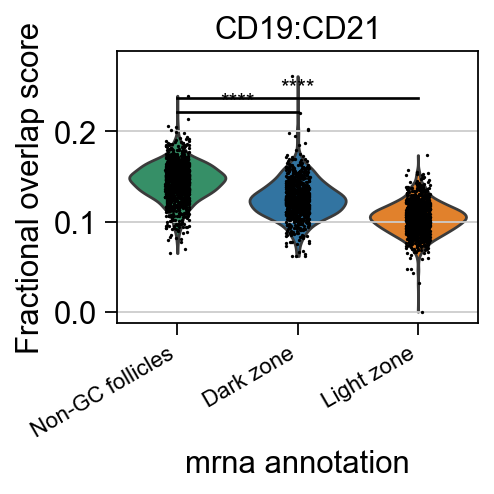

In [189]:
# Call the violin plotting function
fig = plot_violin_with_dynamic_stars(
    adata=adata_fraction_oeverlap_gc_follicle,          
    protein_pair='CD19:CD21',       
    groupby='mrna_annotation',                
    cluster_order=['Non-GC follicles', 'Dark zone', 'Light zone',],
    test_pairs=[('Non-GC follicles', 'Dark zone'), ('Non-GC follicles', 'Light zone'),],             
    figsize=(3.3, 3.3), 
    batch_filter = ['A1'],
    cmap='coolwarm',                 
)
# Show the figure
fig.savefig("figures/Extended-Fig-12b.svg", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/2209543215.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)


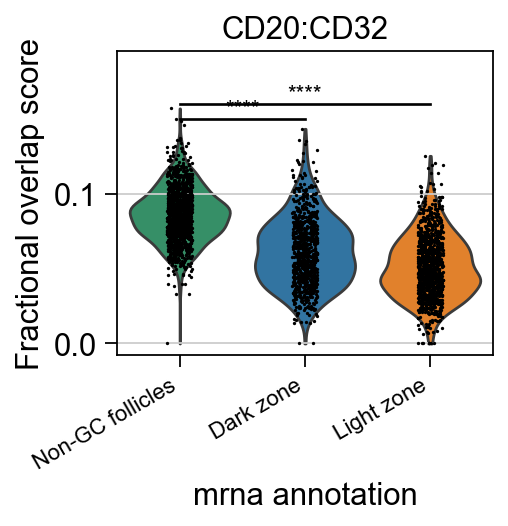

In [190]:
# Call the violin plotting function
fig = plot_violin_with_dynamic_stars(
    adata=adata_fraction_oeverlap_gc_follicle,          
    protein_pair='CD20:CD32',       
    groupby='mrna_annotation',                
    cluster_order=['Non-GC follicles', 'Dark zone', 'Light zone',],
    test_pairs=[('Non-GC follicles', 'Dark zone'), ('Non-GC follicles', 'Light zone'),],             
    figsize=(3.5, 3.5),                  
    cmap='coolwarm',                 
)
# Show the figure
fig.savefig("figures/Fig-5g.svg", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/zq/r1fxzh5j34100gjpvnw5chf40000gp/T/ipykernel_5325/2209543215.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', fontsize=10)


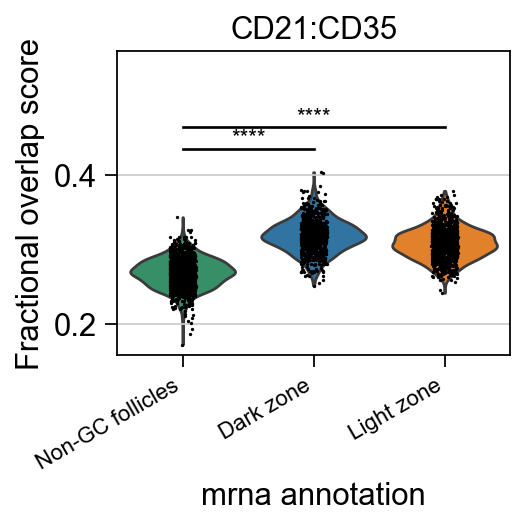

In [193]:
# Call the violin plotting function
fig = plot_violin_with_dynamic_stars(
    adata=adata_fraction_oeverlap_gc_follicle,          
    protein_pair='CD21:CD35',       
    groupby='mrna_annotation',                
    cluster_order=['Non-GC follicles', 'Dark zone', 'Light zone',],
    test_pairs=[('Non-GC follicles', 'Dark zone'), ('Non-GC follicles', 'Light zone'),],             
    figsize=(3.5, 3.5),                  
    cmap='coolwarm',                 
)
# Show the figure
fig.savefig("figures/Fig-5a.svg", dpi=300, bbox_inches='tight')
plt.show()

In [196]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pair_hist_by_batch(
    adata,
    pair,
    zones_to_include=('Dark zone', 'Light zone', 'Non-GC follicles'),
    batches_to_include=None,
    bins=30,
    outdir=None,
    show=True
):
    """
    Plot the histogram of a PLA pair for each batch, colored by zone.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing PLA data.
    pair : str
        The PLA protein pair to plot.
    zones_to_include : tuple
        Zones to include in the plot.
    batches_to_include : list or None
        Specific batches to include (e.g., ['A1', 'B1']). If None, all batches are included.
    bins : int
        Number of histogram bins.
    outdir : str or None
        Directory to save the plot (if not None).
    show : bool
        Whether to display the plot.
    """
    if pair not in adata.var_names:
        print(f"[WARN] {pair} not found in adata.var_names, skipped.")
        return

    # Build DataFrame
    x = adata[:, pair].X
    if hasattr(x, "toarray"):
        x = x.toarray()
    df = pd.DataFrame({
        'value': x.ravel(),
        'batch': adata.obs['batch'].values,
        'zone': adata.obs['mrna_annotation'].values
    })

    # Filter by zones and batches
    df = df[df['zone'].isin(zones_to_include)]
    if batches_to_include is not None:
        df = df[df['batch'].isin(batches_to_include)]

    # Remove unused categories to avoid empty subplots
    if pd.api.types.is_categorical_dtype(df['batch']):
        df['batch'] = df['batch'].cat.remove_unused_categories()
    else:
        if batches_to_include is not None:
            df['batch'] = pd.Categorical(df['batch'], categories=batches_to_include, ordered=True)

    # Define column order
    col_order = (batches_to_include if batches_to_include is not None
                 else df['batch'].unique().tolist())
    col_order = [b for b in col_order if b in df['batch'].unique()]

    # Plot
    sns.set_style("white")
    g = sns.FacetGrid(df, col='batch', col_order=col_order,
                      hue='zone', sharex=True, sharey=True,
                      height=4.2, aspect=1.1)
    g.map(sns.histplot, 'value', bins=bins, stat='density',
          common_norm=False, element='step', fill=False)

    g.set_axis_labels("Scaled fractional overlap", "Density")
    g.add_legend(title='Zone')
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'{pair} distribution across batches')

    # Save or show
    if outdir is not None:
        os.makedirs(outdir, exist_ok=True)
        fname = os.path.join(outdir, f"{pair.replace(':','_')}_hist.svg")
        g.savefig(fname, dpi=300, bbox_inches='tight')
        print(f"Saved: {fname}")

    if show:
        plt.show()
    else:
        plt.close(g.fig)


def plot_many_pairs(adata, pairs, **kwargs):
    """
    Plot histograms for multiple PLA pairs.

    Parameters
    ----------
    adata : AnnData
        AnnData object.
    pairs : list
        List of PLA protein pairs.
    **kwargs : dict
        Additional arguments passed to `plot_pair_hist_by_batch`.
    """
    for p in pairs:
        plot_pair_hist_by_batch(adata, p, **kwargs)


Saved: Figures/Extended-Fig-5b/CD21_CD35_hist.svg


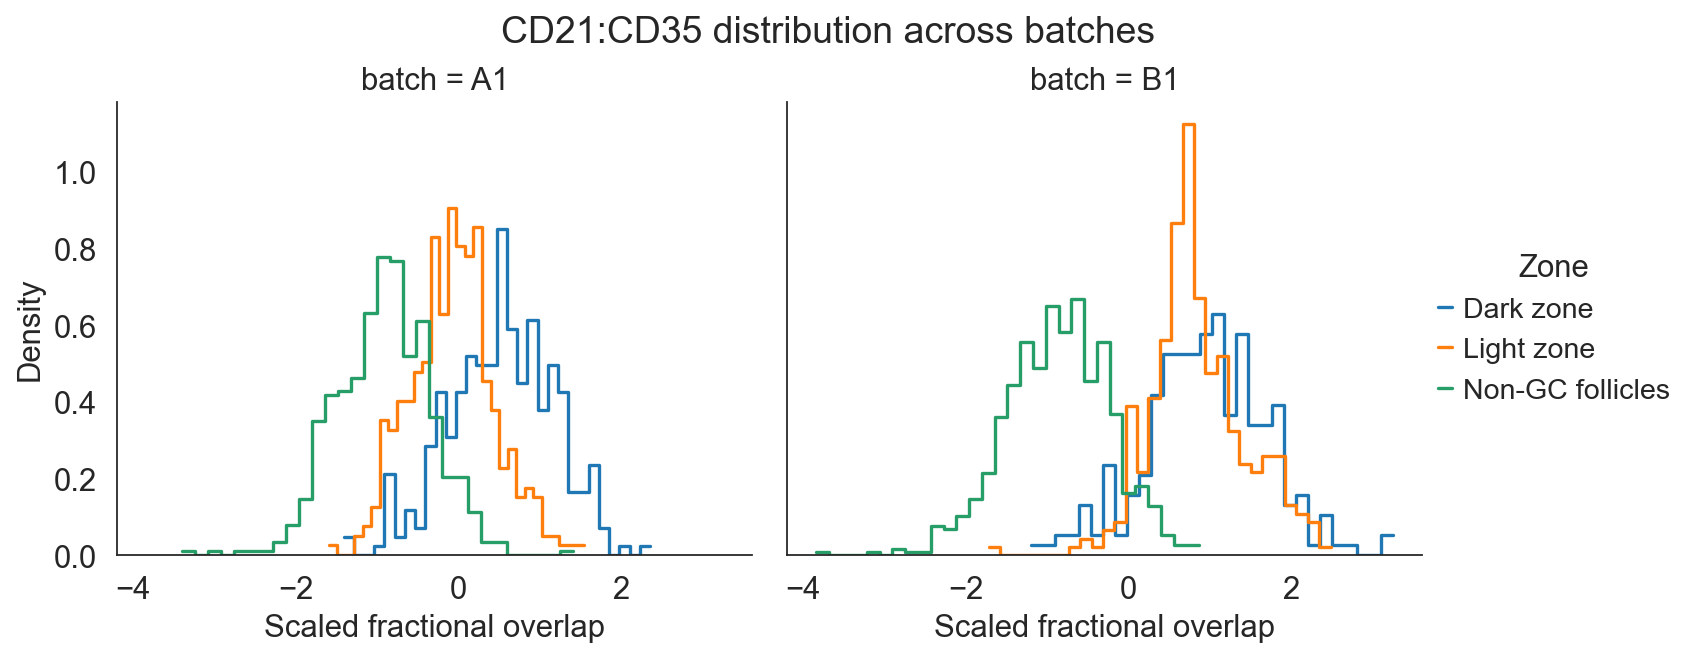

In [198]:
plot_many_pairs(
     adata=adata_fraction_oeverlap_gc_follicle,  
    pairs=['CD21:CD35', ],
    batches_to_include=['A1', 'B1'],  # Only include A1 and B1
    outdir='Figures/Fig-5b',
    zones_to_include=('Dark zone', 'Light zone', 'Non-GC follicles'),
    bins=30,
    show=True
)

Saved: Figures/Extended-Fig-5g/CD19_CD21_hist.svg


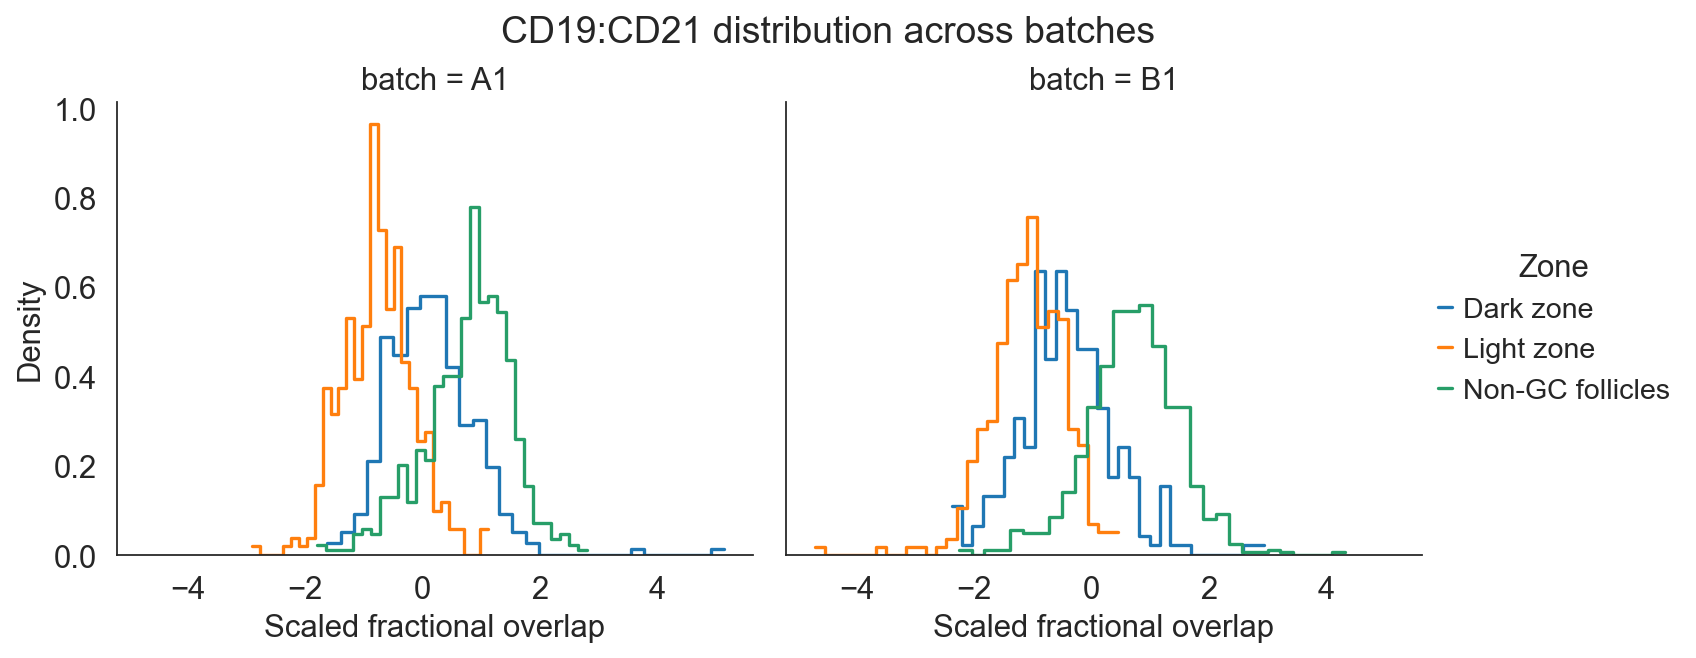

In [199]:
plot_many_pairs(
     adata=adata_fraction_oeverlap_gc_follicle,  
    pairs=['CD19:CD21', ],
    batches_to_include=['A1', 'B1'],  # Only include A1 and B1
    outdir='Figures/Extended-Fig-12c',
    zones_to_include=('Dark zone', 'Light zone', 'Non-GC follicles'),
    bins=30,
    show=True
)

Saved: Figures/Fig-5g/CD20_CD32_hist.svg


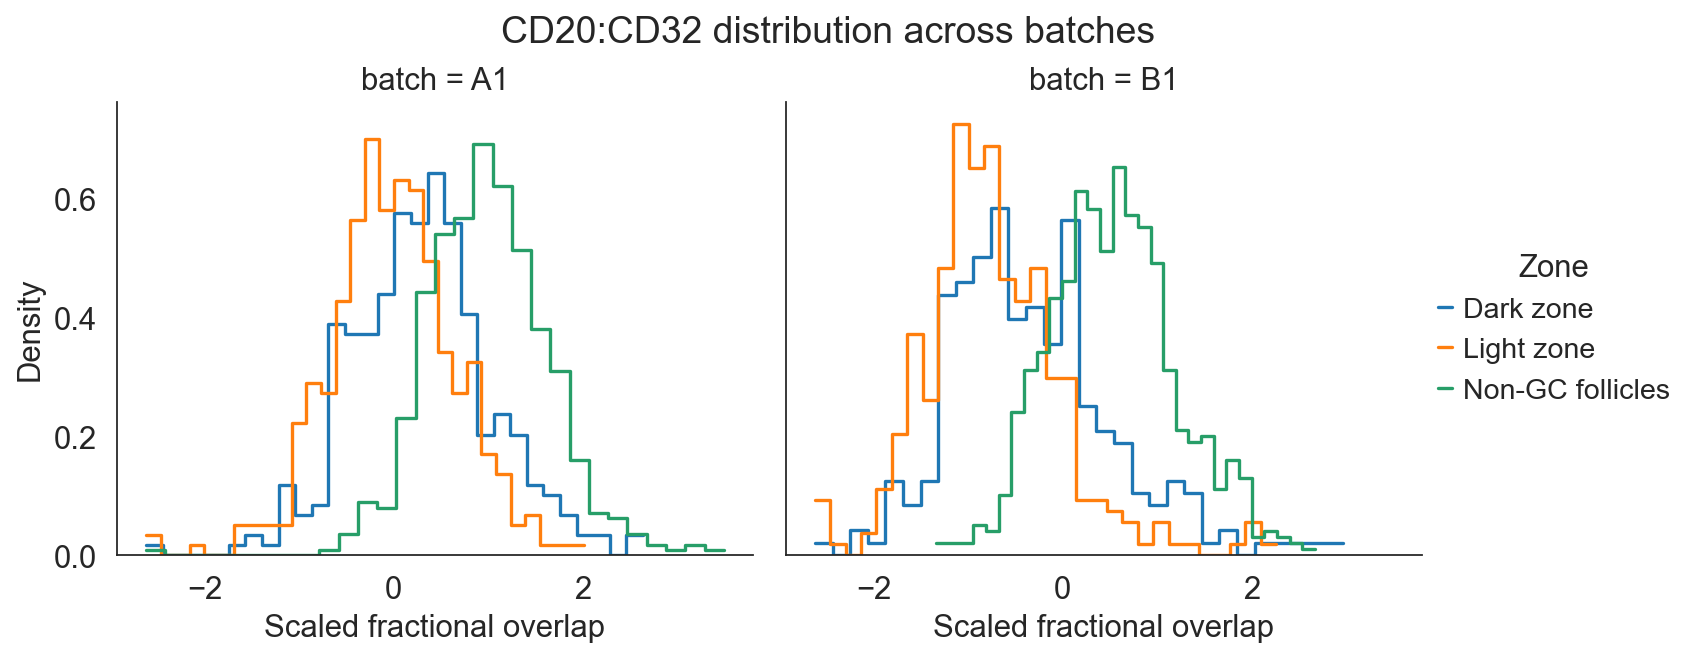

In [200]:
plot_many_pairs(
     adata=adata_fraction_oeverlap_gc_follicle,  
    pairs=['CD20:CD32', ],
    batches_to_include=['A1', 'B1'],  # Only include A1 and B1
    outdir='Figures/Fig-5h',
    zones_to_include=('Dark zone', 'Light zone', 'Non-GC follicles'),
    bins=30,
    show=True
)